In [2]:
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy.constants as const
import jax.numpy as jnp
import jax
import jax.random as random
from copy import deepcopy
import time



In [3]:
#Some lenstronomy imports
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# # import lens model solver with 4 image positions constrains
# from lenstronomy.LensModel.Solver.solver4point import Solver4Point


In [4]:
# from helens import LensEquationSolver
import pandas as pd
from collections import OrderedDict
from functools import partial
from herculens.Util import param_util, plot_util
# from herculens.Util import param_util
import functools
import herculens as hcl
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
import jax
jax.config.update("jax_enable_x64", True)


In [5]:
key = random.PRNGKey(42)
key


Array([ 0, 42], dtype=uint32)

In [6]:
# probabilistic model and variational inference
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.handlers import seed
from numpyro.infer.autoguide import AutoNormal, AutoDelta, AutoMultivariateNormal
from numpyro.infer.reparam import LocScaleReparam
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_median, init_to_feasible, init_to_value
from numpyro.distributions import constraints
from numpyro.distributions import transforms
# NUTS Hamiltonian MC sampling
import blackjax
# import numpyro.constraints as constraints


# #Helens
# from helens import LensEquationSolver


In [9]:
import dynesty
from dynesty import plotting as dyplot
import corner 
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee','high-vis'])


In [10]:
# Load JAX cosmology functions from the separate module
from jaxcosmo import JAXCosmology 
from astropy.cosmology import FlatLambdaCDM

import lensimage_gw
from fisher import FisherMatrix
import corner_plot


In [11]:
# Create JAX cosmology instance with the same parameters
jax_cosmo = JAXCosmology(H0=67.3, Om0=0.316)
astropy_cosmo = FlatLambdaCDM(H0=67.3, Om0=0.316)
print("JAX Cosmology Functions Loaded!")
print(f"Parameters: H0 = {jax_cosmo.H0} km/s/Mpc, Om0 = {jax_cosmo.Om0}, Ode0 = {jax_cosmo.Ode0}")
print(f"Hubble distance: {jax_cosmo.hubble_distance:.2f} Mpc")
print(f"Astropy Cosmology: H0 = {astropy_cosmo.H0} km/s/Mpc, Om0 = {astropy_cosmo.Om0}, Ode0 = {astropy_cosmo.Ode0}")
print(f"Hubble distance: {astropy_cosmo.hubble_distance:.2f} Mpc")


JAX Cosmology Functions Loaded!
Parameters: H0 = 67.3 km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc
Astropy Cosmology: H0 = 67.3 km / (Mpc s) km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc Mpc


In [12]:
arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6


In [13]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 5.0 # Einstein radius
y0true = 0.3
y1true = 0.2
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model  = MassModel(["SIE", 'SHEAR'])
# lens_mass_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])


#SIS for validation and first pass
# kwargs_lens_true_sis = [
#     {'theta_E': theta_E_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIS
# ]
kwargs_lens_true_sie = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.0001
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * jnp.pi / 180, gamma_ext)
print(gamma1, gamma2)
kwargs_lens_true_sie_shear = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]


0.13732309941975984 0.03937676511671417
-3.090169943749473e-05 9.510565162951537e-05


In [14]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


# Define classes for lenstronomy
lensModel = LensModel(lens_model_list=['SIE','SHEAR'],z_lens = zl_true, z_source=zs_true)
solver = LensEquationSolver(lensModel)

# Convert JAX arrays to regular Python floats for lenstronomy compatibility
kwargs_lens_true_sie_shear_fixed = [
    {
        'theta_E': float(theta_E_true), 
        'e1': float(e1_true), 
        'e2': float(e2_true), 
        'center_x': float(cx0_true), 
        'center_y': float(cy0_true)
    },
    {
        'gamma1': float(gamma1),
        'gamma2': float(gamma2),
        'ra_0': float(0.0),
        'dec_0': float(0.0)
    }
]

# Convert source positions to regular Python floats
y0true_float = float(y0true)
y1true_float = float(y1true)

print("Fixed lens parameters for lenstronomy:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  e1: {kwargs_lens_true_sie_shear_fixed[0]['e1']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e1'])})")
print(f"  e2: {kwargs_lens_true_sie_shear_fixed[0]['e2']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e2'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

# compute image position of full model (with numerical options attached)
x_image_true, y_image_true = solver.image_position_from_source(
    kwargs_lens=kwargs_lens_true_sie_shear_fixed,
    sourcePos_x=y0true_float, 
    sourcePos_y=y1true_float,
    min_distance=0.01, 
    search_window=15, 
    precision_limit=10**(-10), 
    num_iter_max=1200,
    solver='lenstronomy'
)
print('image positions (x coordinates): ', x_image_true)
print('image positions (y coordinates): ', y_image_true)

# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image_true, y_image_true, kwargs_lens_true_sie_shear_fixed)
print('x_source_new:',x_source_new)
print('y_source_new:',y_source_new)
print("the relative precision of the image positions are: ", x_source_new - y0true_float)


Fixed lens parameters for lenstronomy:
  theta_E: 5.0 (type: <class 'float'>)
  e1: 0.13732309941975984 (type: <class 'float'>)
  e2: 0.03937676511671417 (type: <class 'float'>)
  source position: (0.3, 0.2)


image positions (x coordinates):  [ 0.93983855  2.90057564  5.01972316 -4.25658029]
image positions (y coordinates):  [ 5.33193565 -4.22283481 -0.4382769  -1.10487159]
x_source_new: [0.3 0.3 0.3 0.3]
y_source_new: [0.2 0.2 0.2 0.2]
the relative precision of the image positions are:  [ 2.89895330e-11 -2.20640173e-12 -3.99619782e-11 -2.19929630e-12]


Using fixed parameters for plotting:
  theta_E: 5.0 (type: <class 'float'>)
  source position: (0.3, 0.2)


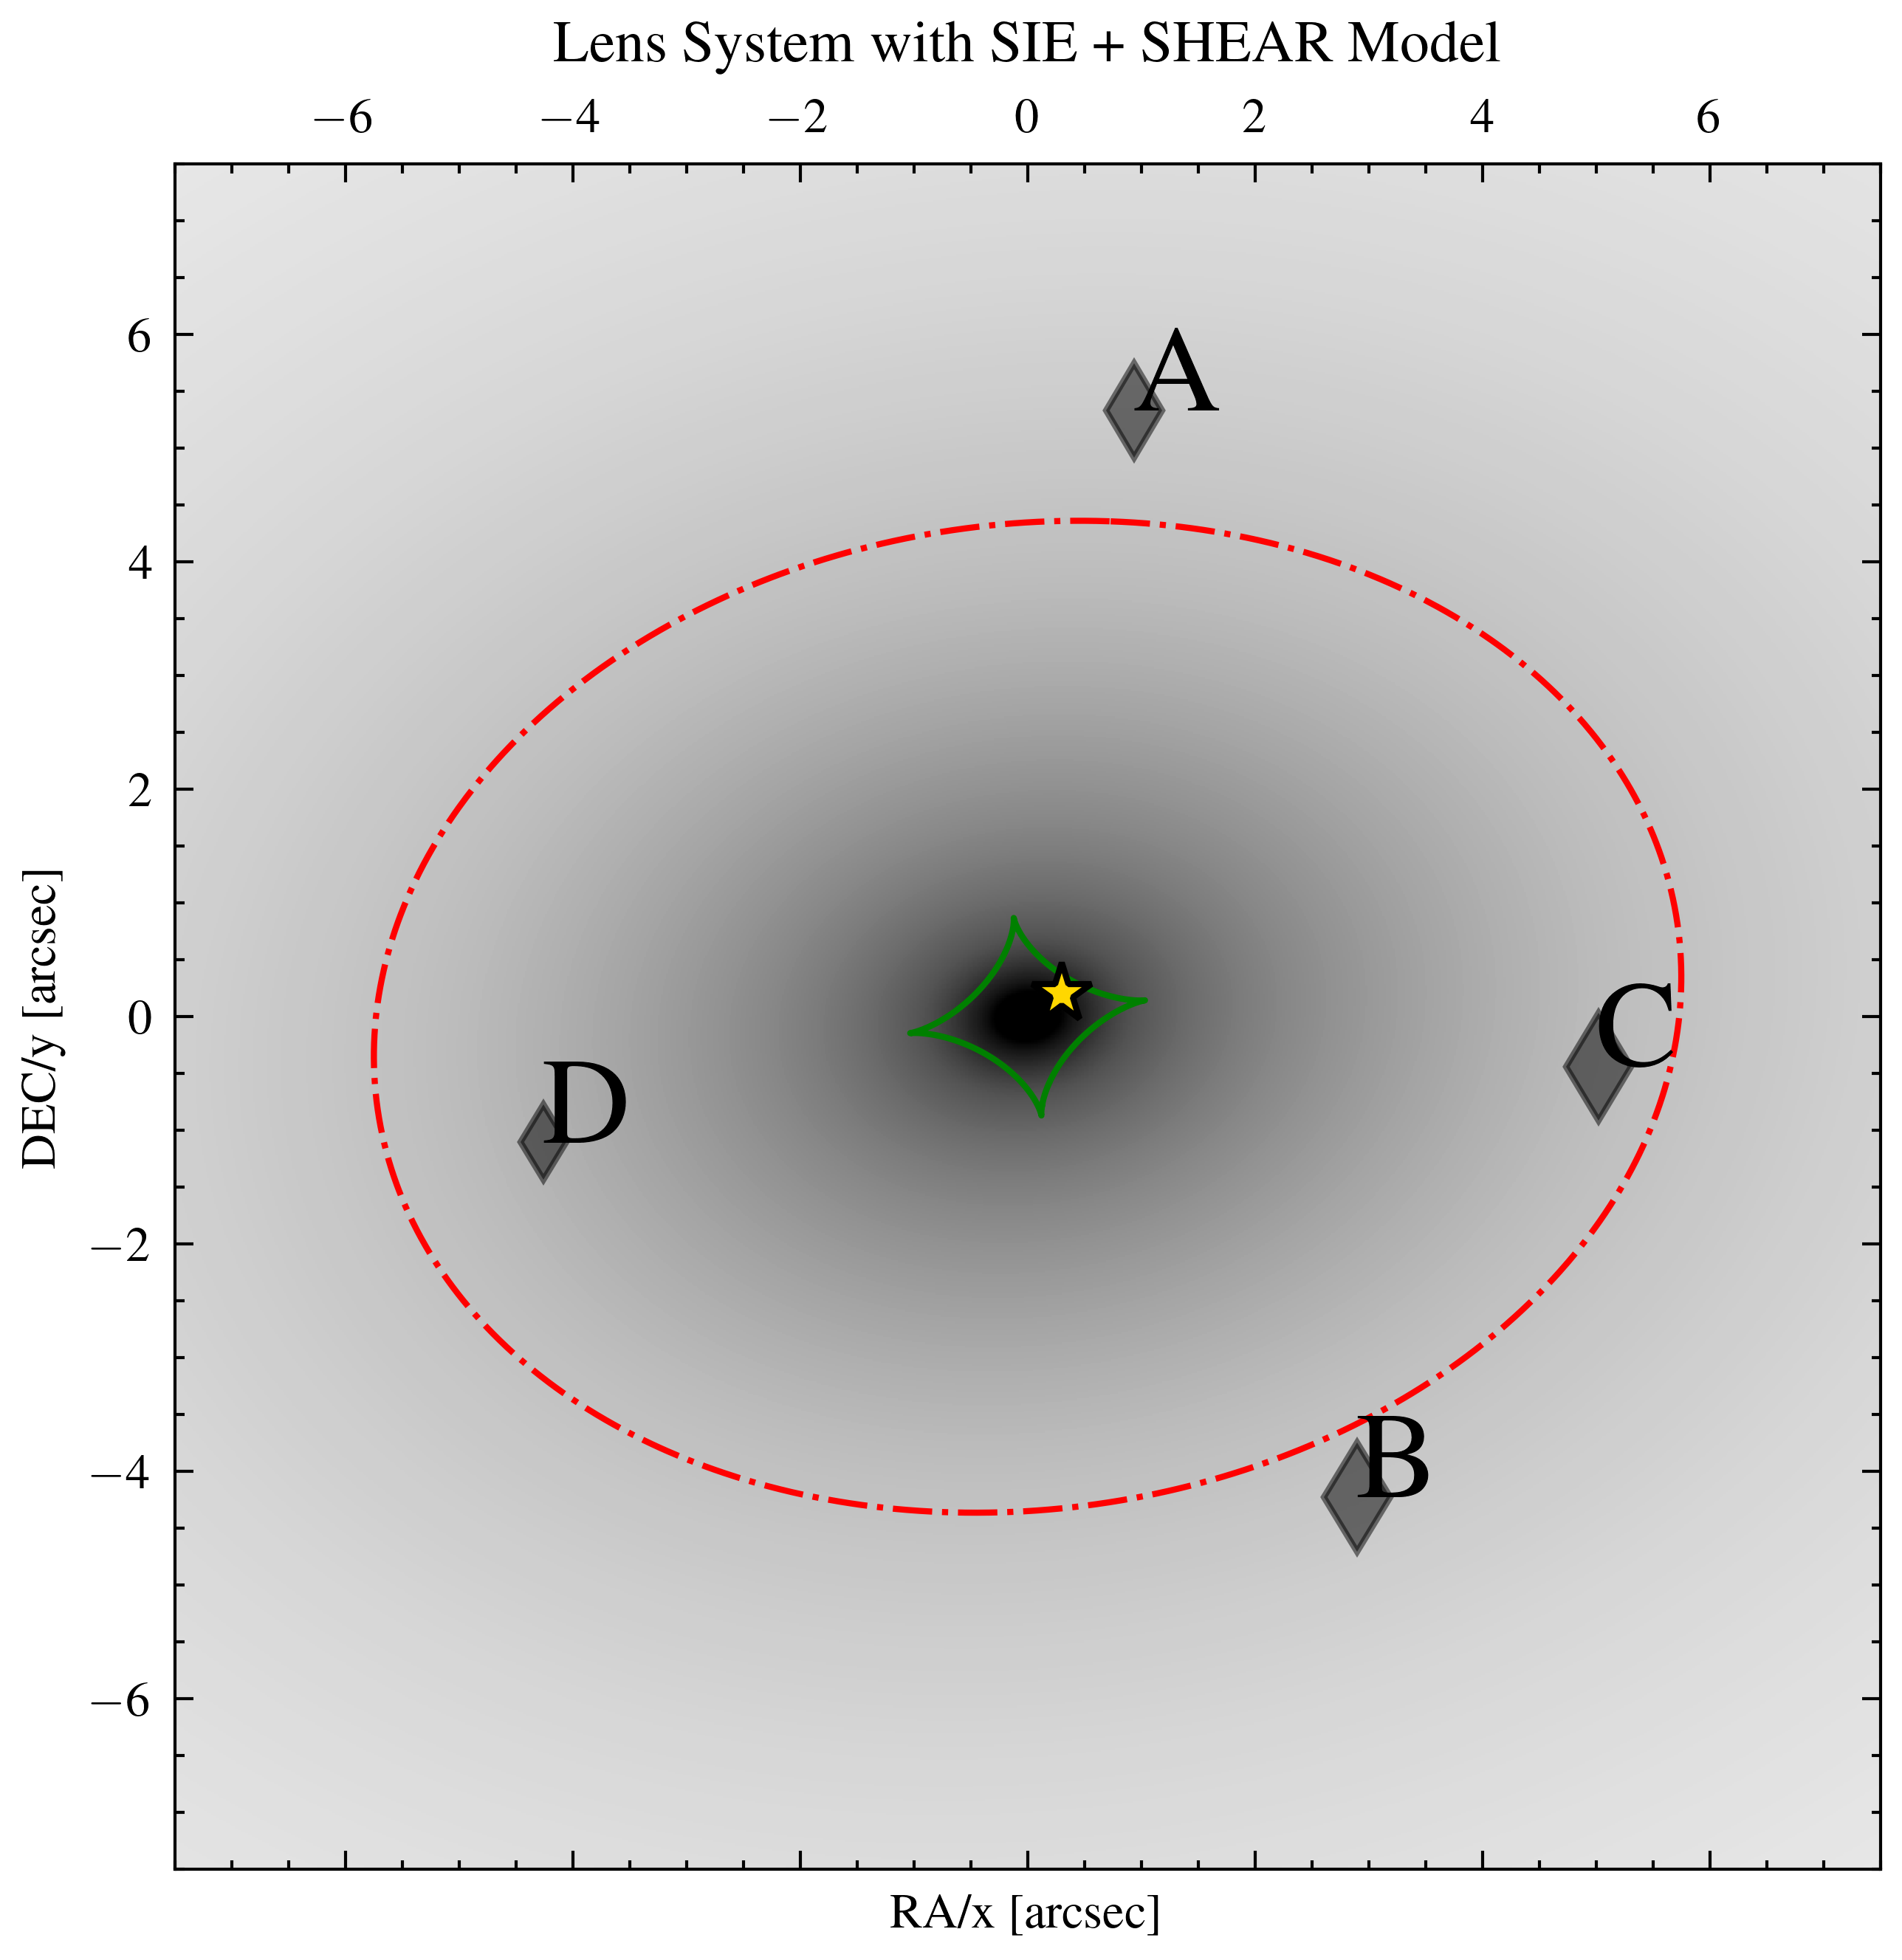

In [15]:
# Plot the lens system (FIXED VERSION)
from lenstronomy.Plots import lens_plot
import matplotlib.pyplot as plt

# Use the fixed parameters (converted to Python floats) for plotting
f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)

# Make sure we have the fixed parameters available
if 'kwargs_lens_true_sie_shear_fixed' not in locals():
    # Convert JAX arrays to regular Python floats for lenstronomy compatibility
    kwargs_lens_true_sie_fixed = [
        {
            'theta_E': float(theta_E_true), 
            'e1': float(e1_true), 
            'e2': float(e2_true), 
            'center_x': float(cx0_true), 
            'center_y': float(cy0_true)
        },
        {
            'gamma1': float(gamma1),
            'gamma2': float(gamma2),
            'ra_0': float(0.0),
            'dec_0': float(0.0)
        }
    ]
    y0true_float = float(y0true)
    y1true_float = float(y1true)

print("Using fixed parameters for plotting:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

lens_plot.lens_model_plot(axex, lensModel=lensModel, kwargs_lens=kwargs_lens_true_sie_shear_fixed, 
                          sourcePos_x=y0true_float, sourcePos_y=y1true_float, 
                          point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False,
                         numPix=1000, deltaPix=0.015,cmap_string="gist_heat")

plt.title("Lens System with SIE + SHEAR Model")
plt.show()


In [17]:
## Set up EM observation


In [18]:
npix = 200  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * jnp.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")


image size : (200, 200) pixels
pixel size : 0.08 arcsec
x range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec
y range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec


In [19]:
psf = hcl.PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

background_rms_simu = 1e-2
exposure_time_simu = 1e3
noise_simu = hcl.Noise(npix, npix, background_rms=background_rms_simu, exposure_time=exposure_time_simu)
noise = hcl.Noise(npix, npix, exposure_time=exposure_time_simu)  # we will sample background_rms


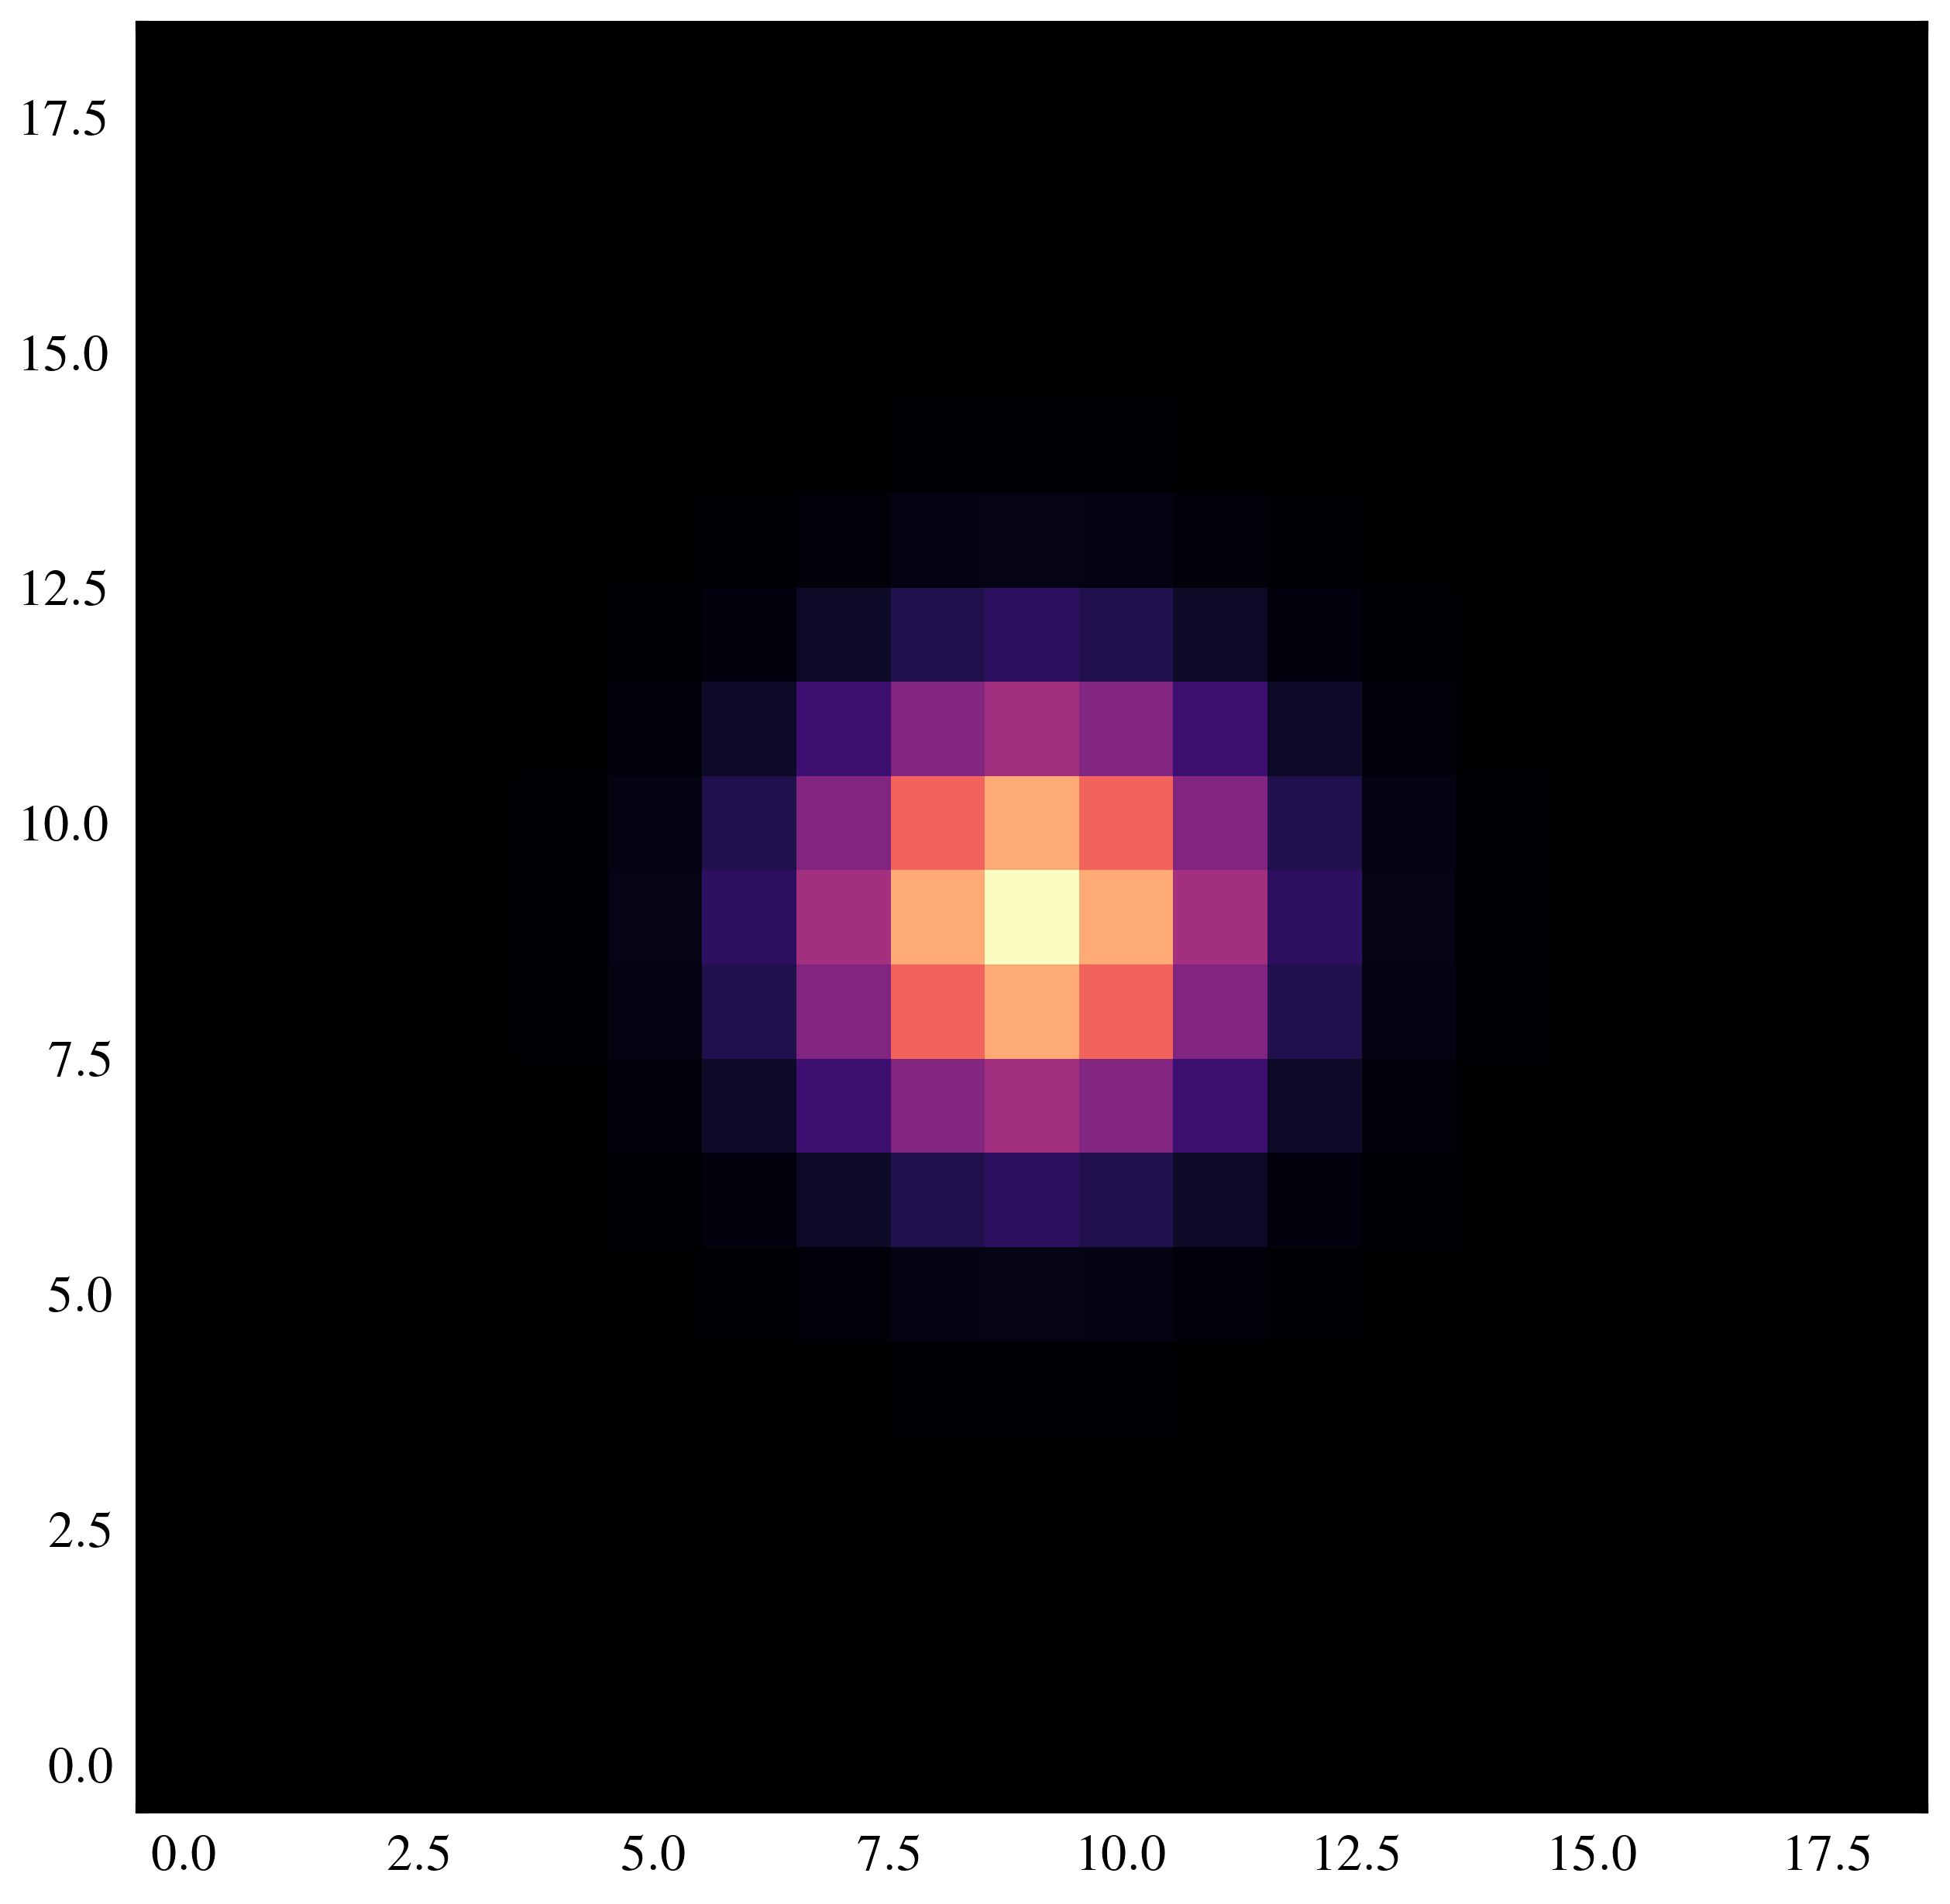

In [22]:
# Compute a Gaussian PSF kernel with given pixel scale, FWHM, and truncation (e.g. 6 * sigma)
plt.figure(figsize=(5.3,5))
kernel = psf.compute_gaussian_kernel(pix_scl, 0.3, 6)
plt.imshow(kernel, cmap='magma')


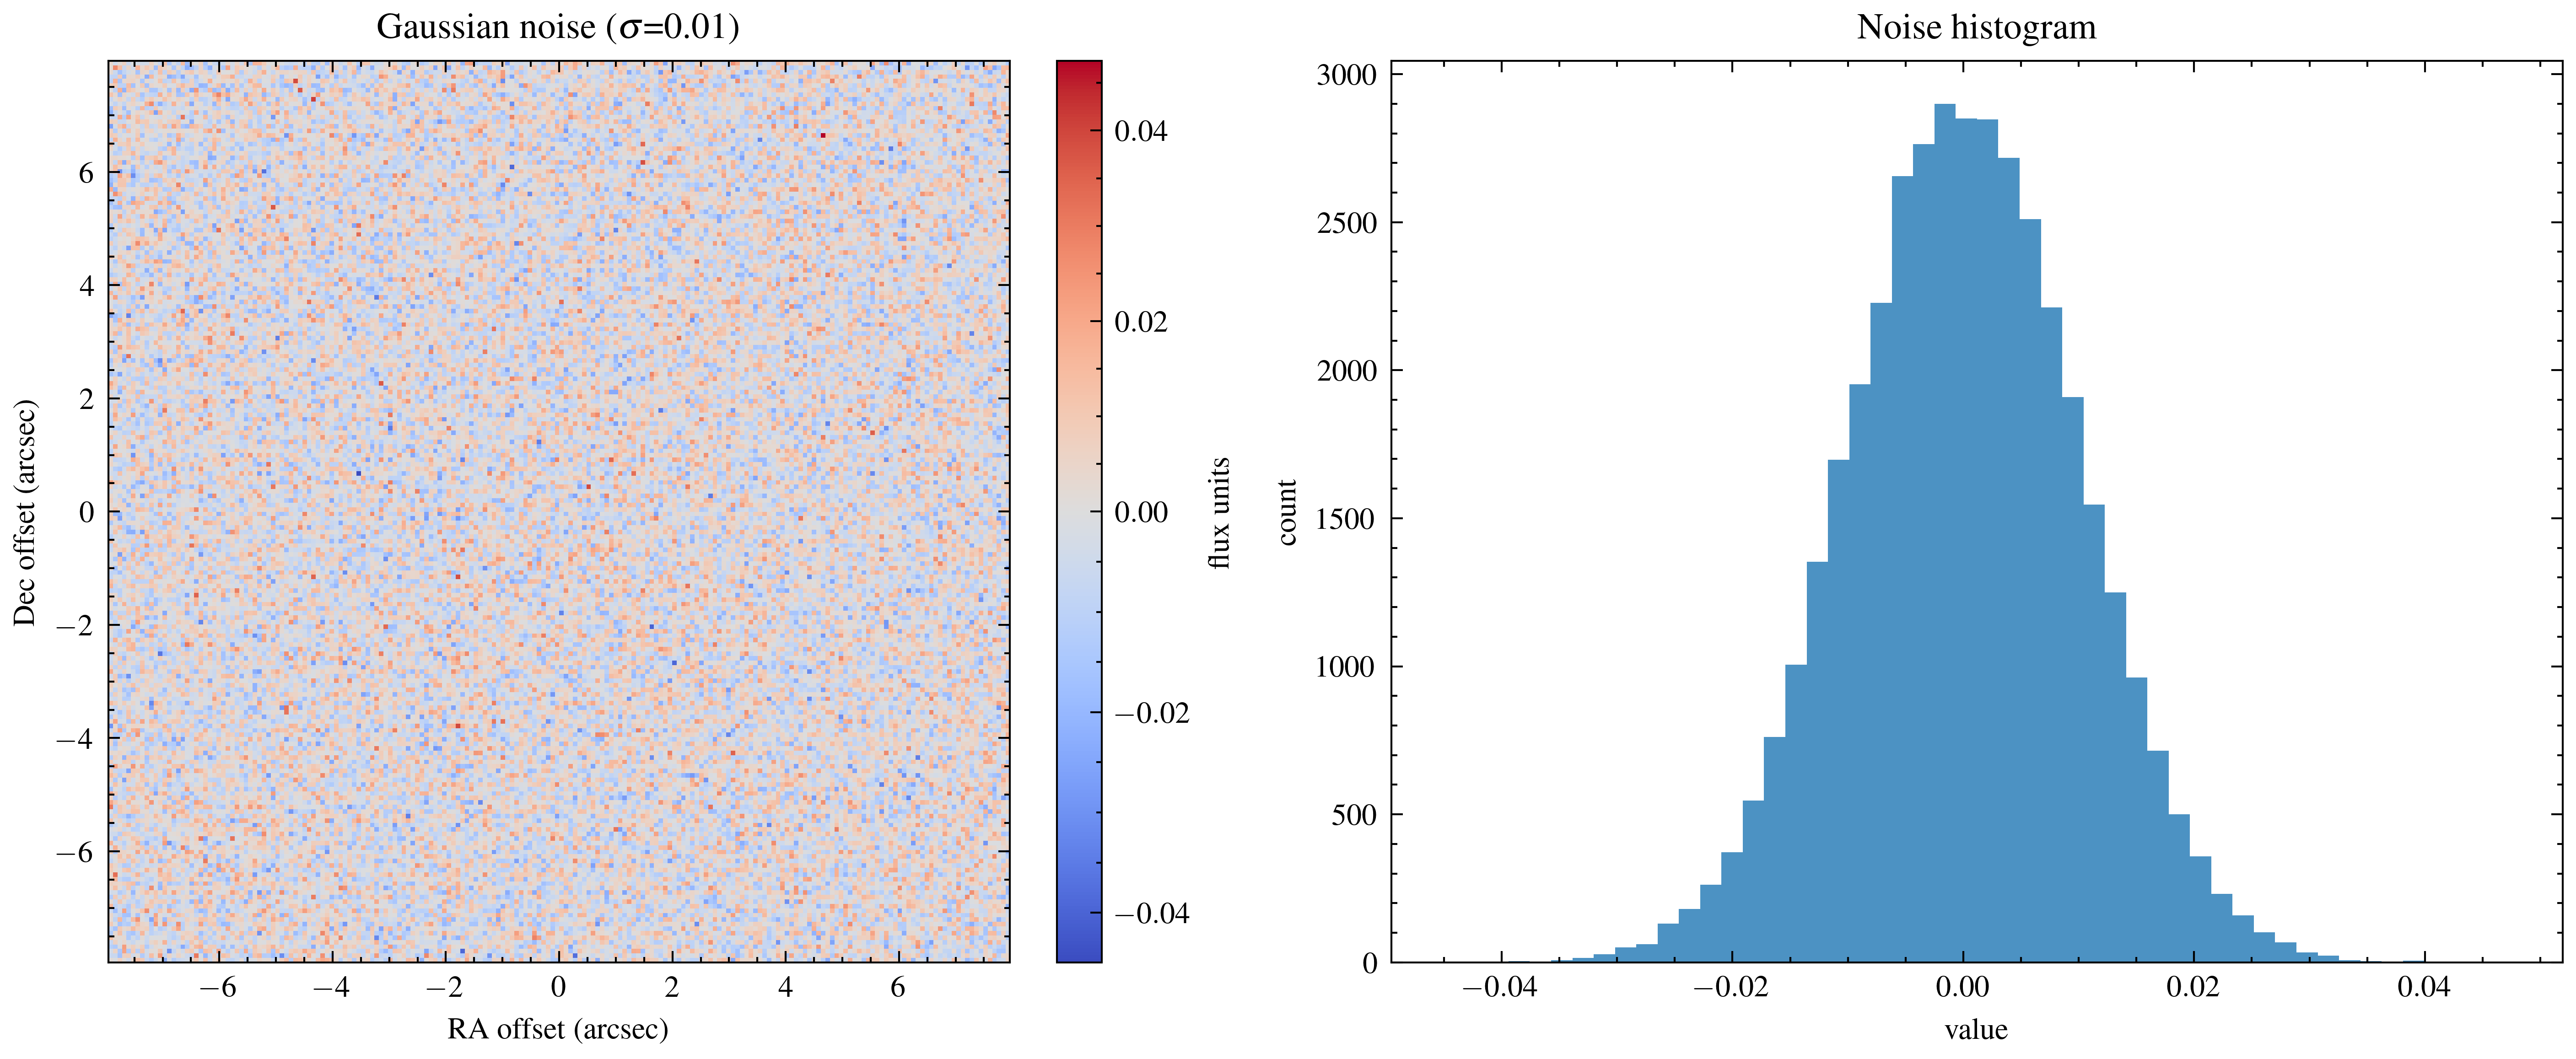

In [23]:
# Visualize background noise map (independent of `hcl.Noise` internals)
import numpy as np
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm


rng = np.random.default_rng(0)
noise_map = rng.normal(loc=0.0, scale=background_rms_simu, size=(npix, npix))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
im = ax.imshow(noise_map, origin='lower', cmap='coolwarm', norm=TwoSlopeNorm(0), extent=extent)
ax.set_title(rf"Gaussian noise ($\sigma$={background_rms_simu})")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='flux units')
ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')

ax = axes[1]
ax.hist(noise_map.ravel(), bins=50, color='tab:blue', alpha=0.8)
ax.set_title('Noise histogram')
ax.set_xlabel('value')
ax.set_ylabel('count')

plt.tight_layout()
plt.show()


In [24]:
# Lens light
lens_light_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}
]
#pprint(kwargs_lens_light_input)

# Source light
y1_em_true = 0.05
y2_em_true = 0.1
e1_em_s_true = 0.05
e2_em_s_true = 0.05 
source_model_input = hcl.LightModel([hcl.SersicElliptic()])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.5, 'n_sersic': 2., 'e1': e1_em_s_true, 'e2': e2_em_s_true, 'center_x': y1_em_true, 'center_y': y2_em_true}
]


In [25]:
# Generate a lensed image based on source and lens models (Mock EM data)
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise_simu,
                         lens_mass_model_class=lens_mass_model,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_true_sie_shear_fixed,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
SEED = 87651  # fixes the stochasticity
key = jax.random.PRNGKey(SEED)
key, key_sim = jax.random.split(key)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_sim)


In [26]:
# Plotting engine
plotter = hcl.Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)


In [27]:
xx, yy = pixel_grid.pixel_coordinates


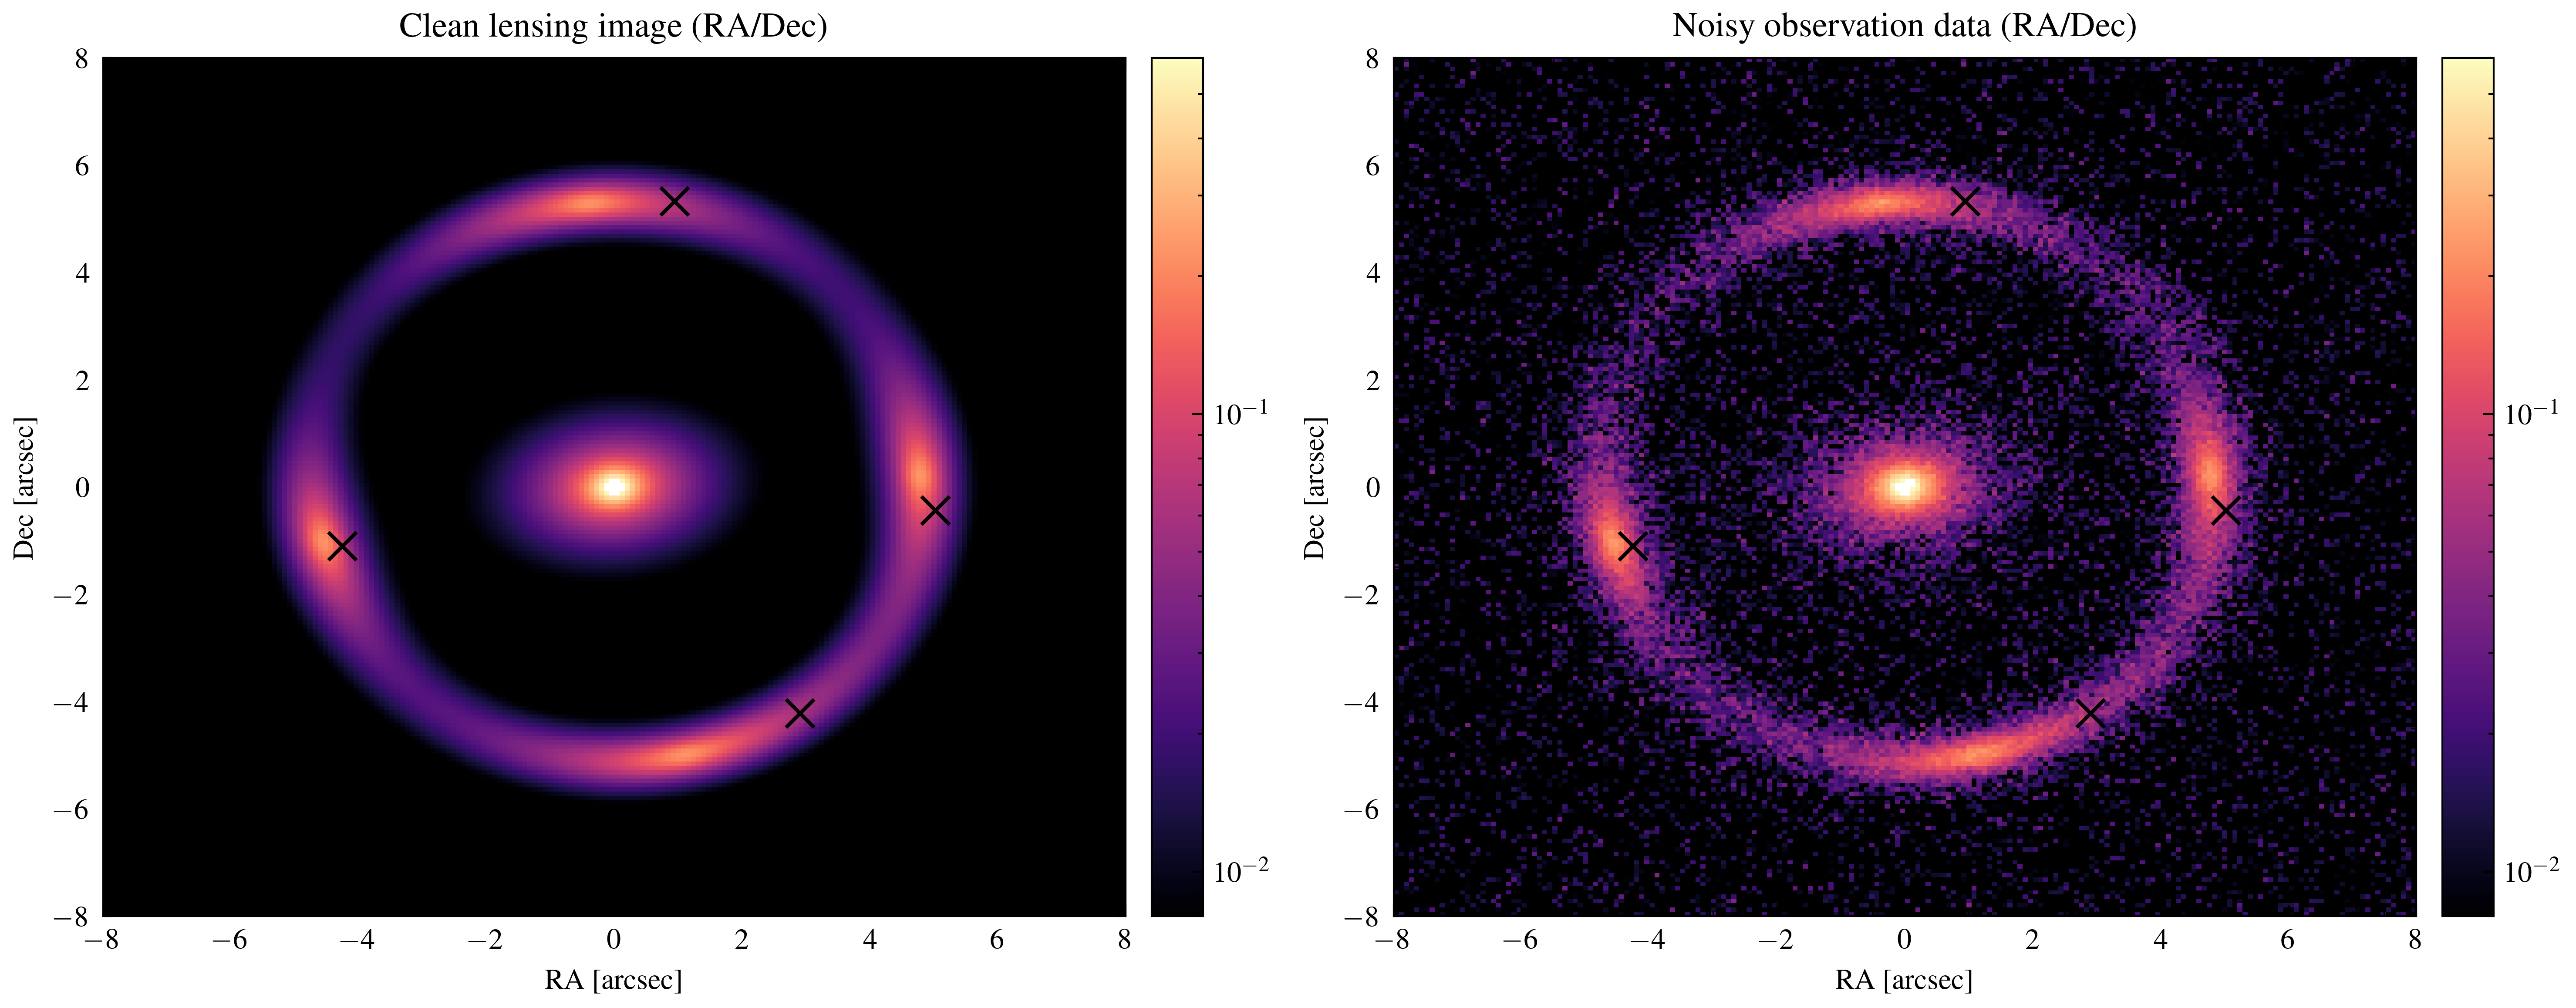

In [28]:
# visualize simulated products using the image grid xx and yy and scatter image positions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot clean image
img1 = ax1.pcolormesh(xx, yy, image, shading='auto', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image (RA/Dec)")
ax1.set_xlabel("RA [arcsec]")
ax1.set_ylabel("Dec [arcsec]")

# Scatter the true image positions
ax1.scatter(x_image_true, y_image_true, color='black', marker='x', s=60)
# ax1.legend()

# Plot noisy data
img2 = ax2.pcolormesh(xx, yy, data, shading='auto', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img2)
ax2.set_title("Noisy observation data (RA/Dec)")
ax2.set_xlabel("RA [arcsec]")
ax2.set_ylabel("Dec [arcsec]")

# Scatter the true image positions
ax2.scatter(x_image_true, y_image_true, color='black', marker='x', s=60)
# ax2.legend()

fig.tight_layout()
plt.show()


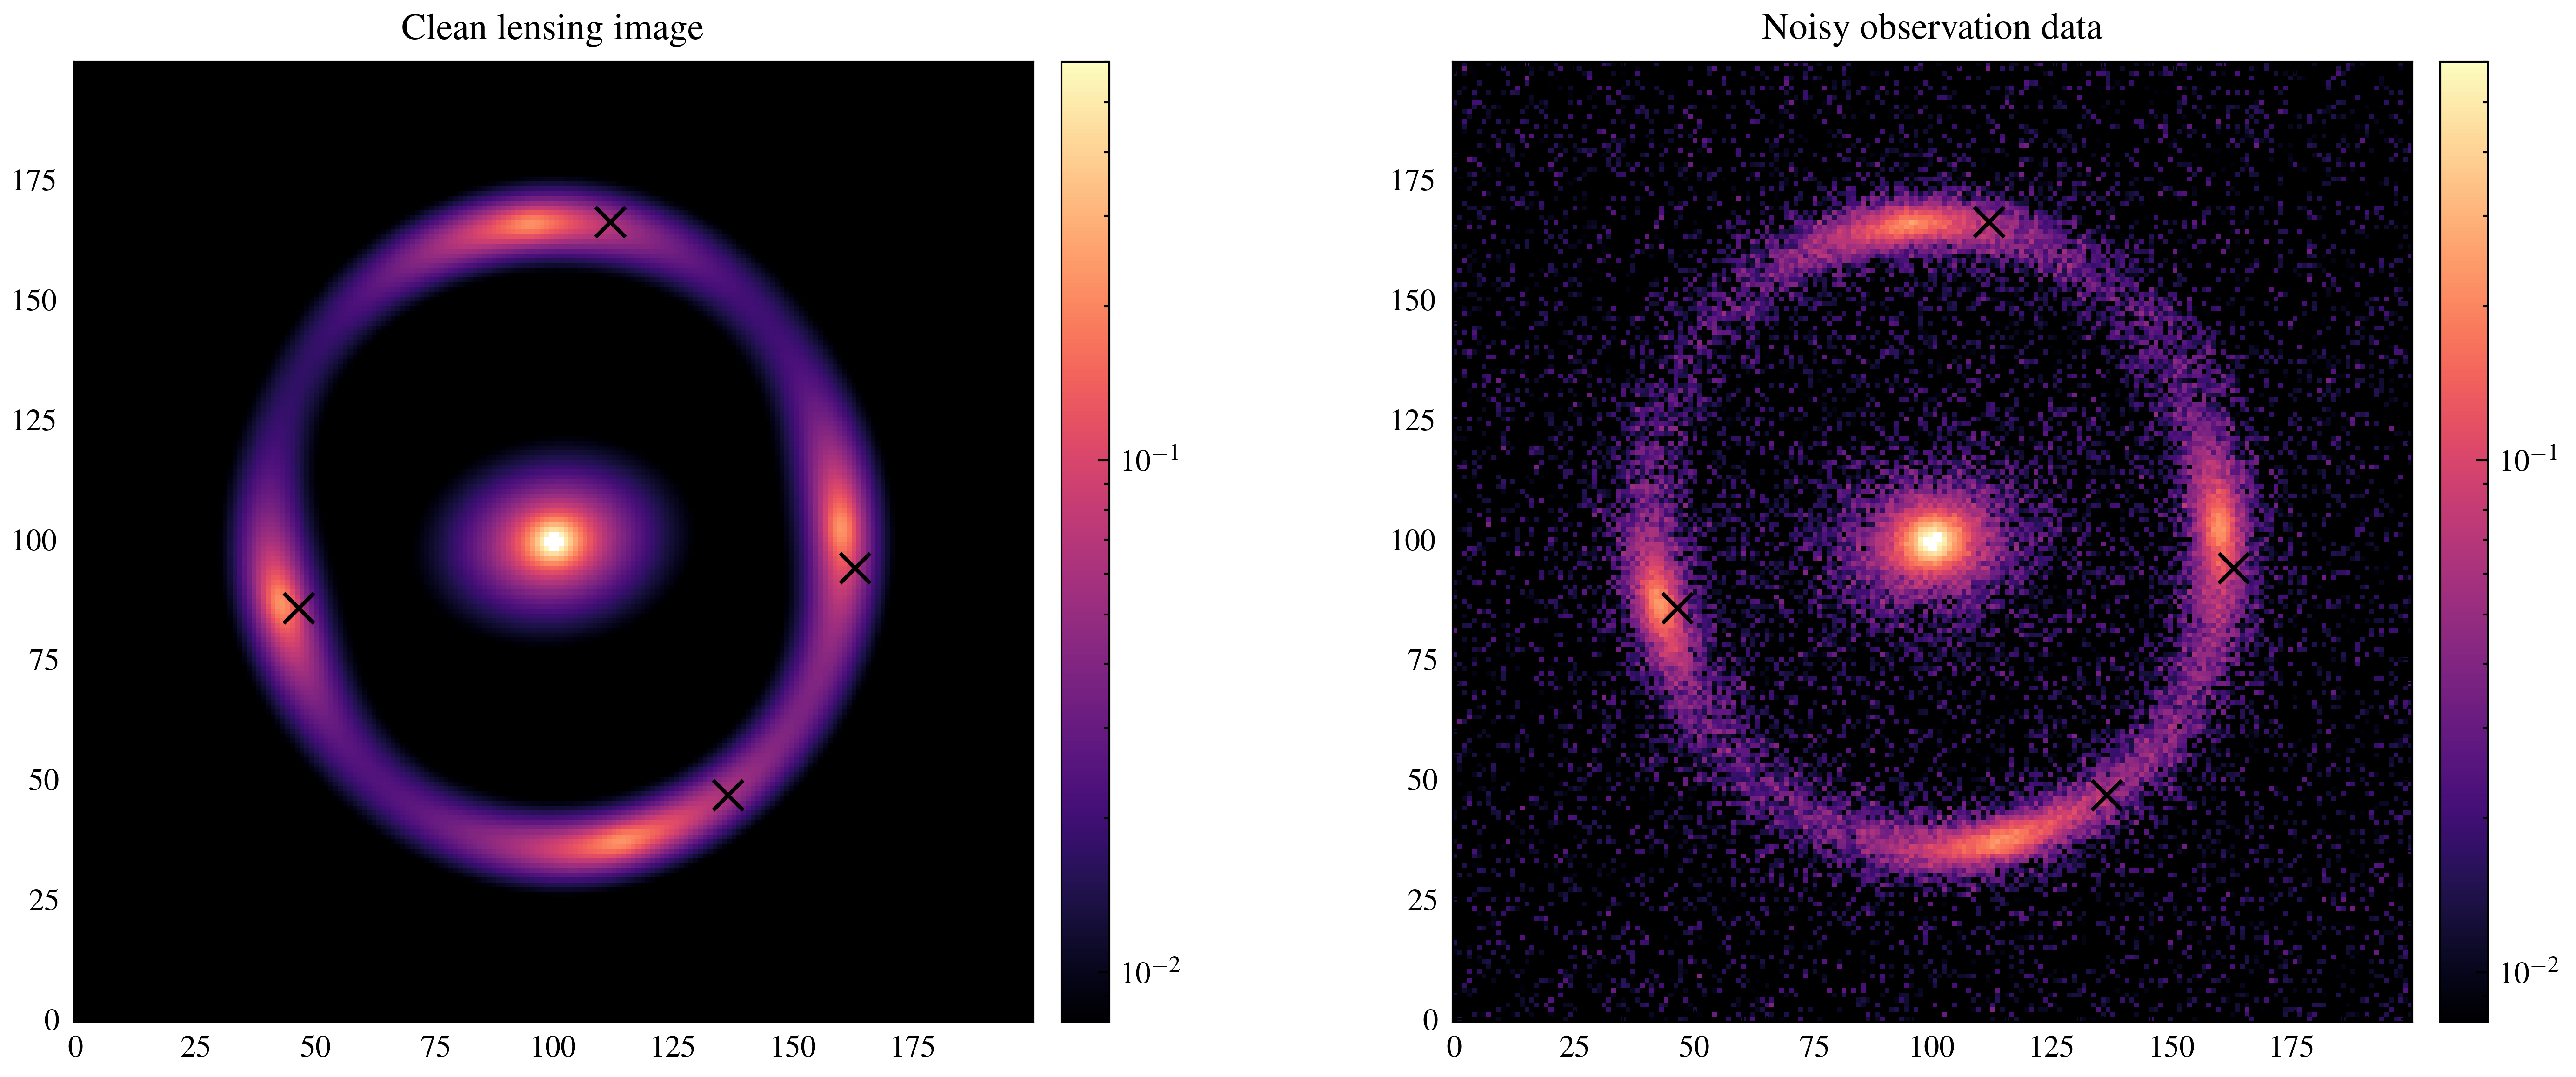

In [29]:
#Get pixel coordinate of gw images
x_pix_gw, y_pix_gw = pixel_grid.map_coord2pix(x_image_true, y_image_true)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
ax1.scatter(x_pix_gw, y_pix_gw, color='black', marker='x', s=60, label='GW')
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
ax2.scatter(x_pix_gw, y_pix_gw, color='black', marker='x', s=60, label='GW')
fig.tight_layout()
plt.show()


In [30]:
kwargs_numerics_fit = {'supersampling_factor': 2}
lens_image = hcl.LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model),
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)


In [31]:
tarrival_lt = lensModel.arrival_time(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
phi_lt = lensModel.fermat_potential(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
magnifications_lt = lensModel.magnification(x_image_true,y_image_true,kwargs_lens_true_sie_shear_fixed)
print(phi_lt)
print(magnifications_lt)

print(tarrival_lt)
print(jnp.diff(tarrival_lt)) # in days


[-14.59051491 -13.0588558  -12.63044923  -9.60442232]
[ 5.46367268  8.66928312 -8.06591852 -3.26534307]
[-1255.59720402 -1123.78918267 -1086.92234911  -826.51543686]
[131.80802135  36.86683357 260.40691225]


In [32]:
# Create  a mock GW observation
# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 
time_delay_distance_true = jax_cosmo.time_delay_distance(zl_true, zs_true) #with Mpc unit
print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)

x_image_true = jnp.array(x_image_true)
y_image_true = jnp.array(y_image_true)

lens_gw = lensimage_gw.LensImageGW(lens_mass_model)
data_GW = lens_gw.compute(x_image_true,y_image_true,kwargs_lens_true_sie_shear,time_delay_distance_true)

print(data_GW)

dL_true = jax_cosmo.luminosity_distance(zs_true)
magnifications_true = data_GW['mu']
dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
time_delays_true = data_GW['time_delays_in_seconds']
gw_obs = {
    'time_delays': time_delays_true, 
    'dL_eff': dL_effectives_true
}

print(gw_obs)


Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]: 3088.8635805953313
{'beta_x': Array([0.3, 0.3, 0.3, 0.3], dtype=float64), 'beta_y': Array([0.2, 0.2, 0.2, 0.2], dtype=float64), 'psi': Array([27.96359333, 26.22108648, 23.97204131, 20.83697923], dtype=float64), 'mu': Array([ 5.4636646 ,  8.66926348, -8.06515447, -3.26534307], dtype=float64), 'phi_in_arcsecsq': Array([-14.59051491, -13.0588558 , -12.63044923,  -9.60442232], dtype=float64), 'Tstar_in_seconds': Array(7472713.02060066, dtype=float64), 'tarrivals_in_seconds': Array([-1.09030731e+08, -9.75850817e+07, -9.43837224e+07, -7.17710917e+07],      dtype=float64), 'tarrivals_days': Array([-1261.92975406, -1129.45696468, -1092.40419483,  -830.68393162],      dtype=float64), 'time_delays_in_seconds': Array([11445649.00293513,  3201359.3144533 , 22612630.74181636], dtype=float64), 'time_delays_in_days': Array([132.47278939,  37.05276984, 261.72026322], dtype=float64)}
{'time_delays': Array([11445649.00293513,  3201359.3144533 , 2261

In [33]:
em_obs = {'data':data}
print(em_obs['data'].shape)
gw_obs

(200, 200)


{'time_delays': Array([11445649.00293513,  3201359.3144533 , 22612630.74181636], dtype=float64),
 'dL_eff': Array([6822.27176334, 5416.01589014, 5615.19297554, 8824.83557824],      dtype=float64)}

In [34]:
class ProbModel(hcl.NumpyroModel):
    def __init__(self, n_images=4, gw_observations=None, em_observations=None):
    
        self.n_images = n_images
        self.gw_observations = gw_observations or {}
        self.em_observations = em_observations or {}
        super().__init__()
        
        # Store likelihood values
        self.em_loglike = 0.0
        self.gw_loglike = 0.0
        self.prior_loglike = 0.0
        self.combined_loglike = 0.0

    def model(self):
        # Track prior contributions
        prior_loglike = 0.0
        zs = numpyro.sample('zs', dist.Uniform(1.0, 10.0))
        prior_loglike += dist.Uniform(1.0, 10.0).log_prob(zs)
        
        zl = numpyro.sample('zl', dist.Uniform(0.0, zs-0.0001))
        prior_loglike += dist.Uniform(0.0, zs-0.0001).log_prob(zl)
        
        # Image positions
        image_positions = []
        x_pos_array = []
        y_pos_array = []
        for i in range(self.n_images):
            # X positions
            x_pos = numpyro.sample(f'image_x{i+1}', dist.Uniform(-10, 10))
            prior_loglike += dist.Uniform(-10, 10).log_prob(x_pos)
            
            # Y positions
            y_pos = numpyro.sample(f'image_y{i+1}', dist.Uniform(-10, 10))
            prior_loglike += dist.Uniform(-10, 10).log_prob(y_pos)
            
            image_positions.append((x_pos, y_pos))
            x_pos_array.append(x_pos)
            y_pos_array.append(y_pos)
        
        x_pos_array = jnp.array(x_pos_array)
        y_pos_array = jnp.array(y_pos_array)
        # Parameters of the source
        source_amp = numpyro.sample('source_amp', dist.TruncatedNormal(4.0, 1.0, low=0.0, high=10.0))
        prior_loglike += dist.TruncatedNormal(4.0, 1.0, low=0.0, high=10.0).log_prob(source_amp)
        
        source_R_sersic = numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.5, 0.4, low=0.05))
        prior_loglike += dist.TruncatedNormal(0.5, 0.4, low=0.05).log_prob(source_R_sersic)
        
        source_n = numpyro.sample('source_n', dist.Uniform(1., 3.))
        prior_loglike += dist.Uniform(1., 3.).log_prob(source_n)
        
        source_e1 = numpyro.sample('source_e1', dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3).log_prob(source_e1)
        
        source_e2 = numpyro.sample('source_e2', dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0.05, 0.06, low=-0.3, high=0.3).log_prob(source_e2)
        
        source_center_x = numpyro.sample('source_center_x', dist.Normal(0.05, 0.02))
        prior_loglike += dist.Normal(0.05, 0.02).log_prob(source_center_x)
        
        source_center_y = numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))
        prior_loglike += dist.Normal(0.1, 0.02).log_prob(source_center_y)
        
        prior_source = [
            {'amp': source_amp,
            'R_sersic': source_R_sersic, 
            'n_sersic': source_n, 
            'e1': source_e1,
            'e2': source_e2,
            'center_x': source_center_x, 
            'center_y': source_center_y}
            ]

        # Parameters of the lens light that are used for the lens mass
        cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
        prior_loglike += dist.Normal(0., pix_scl/2.).log_prob(cx)
        
        cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))
        prior_loglike += dist.Normal(0., pix_scl/2.).log_prob(cy)
        
        e1 = numpyro.sample('light_e1', dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3).log_prob(e1)
        
        e2 = numpyro.sample('light_e2', dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.2, low=-0.3, high=0.3).log_prob(e2)

        # Parameters of the lens light, with center relative the lens mass
        light_amp = numpyro.sample('light_amp', dist.TruncatedNormal(8, 2.0, low=0.0, high=15.0))
        prior_loglike += dist.TruncatedNormal(8, 2.0, low=0.0, high=15.0).log_prob(light_amp)
        
        light_R_sersic = numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.5))
        prior_loglike += dist.Normal(1.0, 0.5).log_prob(light_R_sersic)
        
        light_n = numpyro.sample('light_n', dist.Uniform(2., 5.))
        prior_loglike += dist.Uniform(2., 5.).log_prob(light_n)
        
        prior_lens_light = [
            {'amp': light_amp, 
            'R_sersic': light_R_sersic, 
            'n_sersic': light_n, 
            'e1': e1,
            'e2': e2,
            'center_x': cx, 
            'center_y': cy}
            ]

        # Lens mass parameters
        lens_theta_E = numpyro.sample('lens_theta_E', dist.TruncatedNormal(5, 2, low=0.01, high=10.0))
        prior_loglike += dist.TruncatedNormal(5, 2, low=0.01, high=10.0).log_prob(lens_theta_E)
        
        lens_e1 = numpyro.sample('lens_e1', dist.Normal(e1, 0.05))
        prior_loglike += dist.Normal(e1, 0.05).log_prob(lens_e1)
        
        lens_e2 = numpyro.sample('lens_e2', dist.Normal(e2, 0.05))
        prior_loglike += dist.Normal(e2, 0.05).log_prob(lens_e2)
        
        lens_center_x = numpyro.sample('lens_center_x', dist.Normal(cx, 0.05))
        prior_loglike += dist.Normal(cx, 0.05).log_prob(lens_center_x)
        
        lens_center_y = numpyro.sample('lens_center_y', dist.Normal(cy, 0.05))
        prior_loglike += dist.Normal(cy, 0.05).log_prob(lens_center_y)
        
        # External shear parameters
        gamma1 = numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3).log_prob(gamma1)
        
        gamma2 = numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3))
        prior_loglike += dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3).log_prob(gamma2)
        
        sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.Uniform(low=1e-3, high=1e-1))
        prior_loglike += dist.Uniform(low=1e-3, high=1e-1).log_prob(sigma_bkg)

        prior_lens = [
            {'theta_E': lens_theta_E,
            'e1': lens_e1,
            'e2': lens_e2,
            'center_x': lens_center_x, 
            'center_y': lens_center_y},
            # external shear, with fixed origin
            {'gamma1': gamma1, 
            'gamma2': gamma2, 
            'ra_0': 0.0, 'dec_0': 0.0}
            ]        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        

        if self.em_observations:
            # generates the model image
            model_image = lens_image.model(**model_params)
            data = self.em_observations['data']
            # estimate the error per pixel
            
            
            model_var = noise.C_D_model(model_image, background_rms=sigma_bkg)
            model_std = jnp.sqrt(model_var)

            # EM likelihood (already included in the sample statement below)
            em_loglike = dist.Independent(dist.Normal(model_image, model_std), 2).log_prob(data)

            self.em_loglike = em_loglike
            # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=em_loglike)
            # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
            numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
        else:
            self.em_loglike = 0.0

        if self.gw_observations:
            D_dt_model = jax_cosmo.time_delay_distance(zl,zs)
            dL_model = jax_cosmo.luminosity_distance(zs)
            model_gw = lens_gw.compute(x_pos_array,y_pos_array,prior_lens,D_dt_model)
            beta_x = model_gw['beta_x']
            beta_y = model_gw['beta_y']
            betx_x_diff = jnp.diff(beta_x)
            bety_y_diff = jnp.diff(beta_y)
            zeros = jnp.zeros_like(betx_x_diff) 
            ones = jnp.ones_like(betx_x_diff)

            model_time_delays = model_gw['time_delays_in_seconds']
            model_magnifications = model_gw['mu']
            model_dL_eff = dL_model/jnp.sqrt(jnp.abs(model_magnifications))

            # jax.debug.print("model_dL_eff: {model_dL_eff}", model_dL_eff=model_dL_eff-dL_effectives_true)
            # jax.debug.print("model_time_delays: {model_time_delays}", model_time_delays=model_time_delays-time_delays_true)
            # jax.debug.print("model_magnifications: {model_magnifications}", model_magnifications=model_magnifications-magnifications_true)

            # GW likelihood
            sigma_td = 0.05 * time_delays_true
            sigma_dL_eff = 0.05 * dL_effectives_true
            epsilon = 0.005*ones

            numpyro.sample('tdelays_obs', dist.Independent(dist.Normal(model_time_delays, sigma_td), 1), obs=time_delays_true)
            numpyro.sample('dL_eff_obs', dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1), obs=dL_effectives_true)
            # numpyro.sample('betx_x_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=betx_x_diff)
            # numpyro.sample('bety_y_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=bety_y_diff)

            loglike_td = dist.Independent(dist.Normal(model_time_delays, sigma_td), 1).log_prob(time_delays_true)
            loglike_dL_eff = dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1).log_prob(dL_effectives_true)
            # loglike_betx_x_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(betx_x_diff)
            # loglike_bety_y_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(bety_y_diff)

            loglike_gw = loglike_td + loglike_dL_eff #+ loglike_betx_x_diff + loglike_bety_y_diff
            # gw_logprob = self._compute_gw_logprob(zl,zs,image_positions, prior_lens)
            # This line adds the computed GW log-likelihood (gw_loglike) to the model's total log-probability.
            # It effectively incorporates the GW likelihood as an unnormalized factor in the probabilistic model.
            # numpyro.factor('gw_likelihood', gw_logprob)
            self.gw_loglike = loglike_gw
            # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=loglike_gw)
        else:
            self.gw_loglike = 0.0
        
        self.prior_loglike = prior_loglike
        # jax.debug.print("Prior log-likelihood: {prior_loglike}", prior_loglike=self.prior_loglike)
        # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=self.em_loglike)
        # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=self.gw_loglike)
        
        # Combined likelihood (prior + EM + GW)
        
        combined_loglike = self.prior_loglike + self.em_loglike + self.gw_loglike
        self.combined_loglike = combined_loglike
        # jax.debug.print("Combined log-likelihood: {combined_loglike}", combined_loglike=self.combined_loglike)


    
    def params2kwargs(self, params):
        # functions that takes the flatten dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2'],
        'center_x': params['lens_center_x'],
        'center_y': params['lens_center_y']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        'kwargs_source': [{'amp': params['source_amp'],
        'R_sersic': params['source_R_sersic'],
        'n_sersic': params['source_n'],
        'e1': params['source_e1'],
        'e2': params['source_e2'],
        'center_x': params['source_center_x'],
        'center_y': params['source_center_y']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}],
        'zs': params['zs'],
        'zl': params['zl'],
        'image_positions': [
                (params.get(f'image_x{i+1}', 0.0),
                params.get(f'image_y{i+1}', 0.0))
                for i in range(self.n_images)
            ]
        }
        return kw
    
    def get_likelihoods(self):
        """Return the computed likelihood values"""
        # jax.debug.print("Getting likelihoods")
        # jax.debug.print(self.prior_loglike)
        # jax.debug.print(self.em_loglike)
        # jax.debug.print(self.gw_loglike)
        # jax.debug.print(self.combined_loglike)
        return {
            'prior_loglike': self.prior_loglike,
            'em_loglike': self.em_loglike,
            'gw_loglike': self.gw_loglike, 
            'combined_loglike': self.combined_loglike
        }

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 32


In [35]:
gw_model = ProbModel(n_images=4, gw_observations=gw_obs)
print(gw_model.num_parameters)
print("GW Model created with", gw_model.num_parameters, "parameters")
print('*'*100)
em_model = ProbModel(n_images=4, em_observations=em_obs)
print(em_model.num_parameters)
print("EM Model created with", em_model.num_parameters, "parameters")
print('*'*100)

# Create GW model with no fixed parameters
gw_em_model = ProbModel(n_images=4, gw_observations=gw_obs, em_observations=em_obs)
print(gw_em_model.num_parameters)
print("GW-EM Model created with", gw_em_model.num_parameters, "parameters")


32
GW Model created with 32 parameters
****************************************************************************************************
32
EM Model created with 32 parameters
****************************************************************************************************
32
GW-EM Model created with 32 parameters


In [36]:
# create the input vector for reference
input_params = {
    'zs': zs_true,
    'zl': zl_true,
    'image_x1': x_image_true[0],
    'image_y1': y_image_true[0],
    'image_x2': x_image_true[1],
    'image_y2': y_image_true[1],
    'image_x3': x_image_true[2],
    'image_y3': y_image_true[2],
    'image_x4': x_image_true[3],
    'image_y4': y_image_true[3],
    'lens_theta_E': kwargs_all_input['kwargs_lens'][0]['theta_E'],
    'lens_e1': kwargs_all_input['kwargs_lens'][0]['e1'],
    'lens_e2': kwargs_all_input['kwargs_lens'][0]['e2'],
    'lens_center_x': kwargs_all_input['kwargs_lens'][0]['center_x'],
    'lens_center_y': kwargs_all_input['kwargs_lens'][0]['center_y'],
    'lens_gamma1': kwargs_all_input['kwargs_lens'][1]['gamma1'],
    'lens_gamma2': kwargs_all_input['kwargs_lens'][1]['gamma2'],
    'light_amp': kwargs_all_input['kwargs_lens_light'][0]['amp'],
    'light_R_sersic': kwargs_all_input['kwargs_lens_light'][0]['R_sersic'],
    'light_n': kwargs_all_input['kwargs_lens_light'][0]['n_sersic'],
    'light_e1': kwargs_all_input['kwargs_lens_light'][0]['e1'],
    'light_e2': kwargs_all_input['kwargs_lens_light'][0]['e2'],
    'light_center_x': kwargs_all_input['kwargs_lens_light'][0]['center_x'],
    'light_center_y': kwargs_all_input['kwargs_lens_light'][0]['center_y'],
    'source_amp': kwargs_all_input['kwargs_source'][0]['amp'],
    'source_R_sersic': kwargs_all_input['kwargs_source'][0]['R_sersic'],
    'source_n': kwargs_all_input['kwargs_source'][0]['n_sersic'],
    'source_e1': kwargs_all_input['kwargs_source'][0]['e1'],
    'source_e2': kwargs_all_input['kwargs_source'][0]['e2'],
    'source_center_x': kwargs_all_input['kwargs_source'][0]['center_x'],
    'source_center_y': kwargs_all_input['kwargs_source'][0]['center_y'],
    'noise_sigma_bkg': background_rms_simu,
}

# input_params

input_params_flat = jnp.array(list(input_params.values()))

len(input_params_flat)

32

In [37]:
# PRNG key
SEED = 12345
prng_key = jax.random.PRNGKey(SEED)
model_ = gw_model
#Check all the methods in the ProbModel class for gw_model
print("Checking methods in ProbModel class for gw_model...")
# 1. model()
print("Running model() method...")
model_.model
print("model() method executed successfully.")

# Compute log posterior = log prior + log likelihood
print("Computing log posterior...")
log_post = model_.log_prob(input_params,constrained=True)
print("Log posterior computed: {}".format(log_post))

# Calculate likelihoods from get_likelihoods method
log_likes = model_.get_likelihoods()
print("Likelihoods retrieved: {}".format(log_likes))
print("logPrior = {}".format(log_likes['prior_loglike']))
print("logGW = {}".format(log_likes['gw_loglike']))
print("logEM = {}".format(log_likes['em_loglike']))
print("logPost = {}".format(log_likes['combined_loglike']))

# Compute loglikelihood using Numyro utility inbuilt function
print("Computing log likelihood using numpyro utility...")
loglike_util = numpyro.infer.util.log_likelihood(model_.model, input_params)
loglike_util_sum = sum(loglike_util.values())
for key, value in loglike_util.items():
    print(f"{key}: {value}")
print("Total Log likelihood (utility) computed: {}".format(loglike_util_sum))

input_params_unconst = model_.unconstrain(input_params)
print("Input parameters (unconstrained):", input_params_unconst)

# Potential energy (negative log posterior)
print("Computing potential energy...")
potential_energy = numpyro.infer.util.potential_energy(model_.model,(),{}, input_params_unconst)
print("Potential energy computed: {}".format(potential_energy))

# Check log_density function of numpyro
print("Computing log density...")
# Call the log_density function, this is computed in constarined space 
log_density, model_trace = numpyro.infer.util.log_density(model_.model,(),{},input_params)

print("Log density computed: {}".format(log_density))

#get a seeded model
seeded_model = seed(model_.model, prng_key)
trace = numpyro.handlers.trace(seeded_model).get_trace()
print('Trace obtained with {} nodes:'.format(len(trace)))

# same thing obtain using defined function
trace_ = model_.get_trace(prng_key)
assert trace.keys() == trace_.keys()
assert all(jnp.all(trace[key]['value'] == trace_[key]['value']) for key in trace.keys())
print('Trace_ obtained with {} nodes:'.format(len(trace_)))
for name, site in trace.items():
    print(f"{name}: {site['value']}")
    # Check log probability at each node in the trace
    log_prob = site['fn'].log_prob(site['value'])
    print(f"Log probability at {name}: {log_prob}")

# get the site names 
site_names = list(trace.keys())
print("Site names in the trace:", site_names)



Checking methods in ProbModel class for gw_model...
Running model() method...
model() method executed successfully.
Computing log posterior...
Log posterior computed: -72.45901894627654
Likelihoods retrieved: {'prior_loglike': Array(-3.68672963, dtype=float64), 'em_loglike': 0.0, 'gw_loglike': Array(-68.77228932, dtype=float64), 'combined_loglike': Array(-72.45901895, dtype=float64)}
logPrior = -3.6867296271469723
logGW = -68.77228931912957
logEM = 0.0
logPost = -72.45901894627654
Computing log likelihood using numpyro utility...
dL_eff_obs: -26.836445070327
tdelays_obs: -41.93584424880257
Total Log likelihood (utility) computed: -68.77228931912957
Input parameters (unconstrained): {'zs': Array(-2.07944154, dtype=float64, weak_type=True), 'zl': Array(-1.09854562, dtype=float64, weak_type=True), 'image_x1': Array(0.1885241, dtype=float64), 'image_y1': Array(1.18919345, dtype=float64), 'image_x2': Array(0.59725823, dtype=float64), 'image_y2': Array(-0.90093565, dtype=float64), 'image_x3'

In [38]:
# model_trace

In [39]:
# # access the trace element
# trace = numpyro.handlers.trace(seed(gw_model.model,key)).get_trace()
# #print the keys of the trace
# print(trace.keys())

# print('zs', trace['zs']['value'])
# print('zl', trace['zl']['value'])
# print('image_x1', trace['image_x1']['value'])
# print('image_y1', trace['image_y1']['value'])
# print('image_x2', trace['image_x2']['value'])
# print('image_y2', trace['image_y2']['value'])

# print('time delay log-likelihood', trace['tdelays_obs']['value'])
# print('dL_eff log-likelihood', trace['dL_eff_obs']['value'])
# print('betx_x_diff log-likelihood', trace['betx_x_diff']['value'])
# print('bety_y_diff log-likelihood', trace['bety_y_diff']['value'])

# print('GW loglikelihood', gw_model.log_prob(input_params))
# print('GW alternative loglikelihood', gw_model.get_likelihoods())




In [40]:
# with numpyro.handlers.substitute(data=input_params):
#     with numpyro.handlers.seed(rng_seed=42):
#         trace = numpyro.handlers.trace(gw_model.model).get_trace()

In [41]:
# print('time delay log-likelihood:', trace['tdelays_obs']['fn'].log_prob(trace['tdelays_obs']['value']))

In [42]:
# # These are sampled values
# print('time delay log-likelihood', trace['tdelays_obs']['value'])
# print('dL_eff log-likelihood', trace['dL_eff_obs']['value'])
# print('betx_x_diff log-likelihood', trace['betx_x_diff']['value'])
# print('bety_y_diff log-likelihood', trace['bety_y_diff']['value'])

# print('GW loglikelihood', gw_model.log_prob(input_params))
# print('GW alternative loglikelihood', gw_model.get_likelihoods())


In [43]:
# from numpyro.infer.util import potential_energy

# # Empty dict for model params (no latent variables to condition on)
# potential_energy??#(gw_model.model, {}, input_params)

# # print(f"Potential energy: {pe}")
# # This is -log_likelihood (since no priors are evaluated)
# # So: log_likelihood = -pe

In [44]:
# from numpyro.infer.util import log_likelihood

# # This automatically computes log-likelihood for all observed sites
# log_liks = log_likelihood(gw_model.model, input_params)
# print(log_liks['tdelays_obs'])
# print(log_liks['dL_eff_obs'])
# print(log_liks['betx_x_diff'])
# print(log_liks['bety_y_diff'])
# # Sum everything
# total = sum(jnp.sum(v) for v in log_liks.values())
# print(f"Total log-likelihood: {total}")

In [45]:
# with numpyro.handlers.substitute(data=input_params):
#     with numpyro.handlers.seed(rng_seed=42):
#         trace = numpyro.handlers.trace(gw_model.model).get_trace()

# # Sum log probabilities from all sample sites
# total_log_prob = 0.0

# for site_name, site in trace.items():
#     if site['type'] == 'sample':
#         # Compute log probability
#         log_prob = site['fn'].log_prob(site['value'])
        
#         # Handle arrays vs scalars
#         site_log_prob = jnp.sum(log_prob)  # Sum if it's an array
        
#         print(f"{site_name}: {site_log_prob}")
#         total_log_prob += site_log_prob

# print(f"\nTotal log probability: {total_log_prob}")

In [46]:
# from numpyro.infer.util import potential_energy

# pe = potential_energy(
#     gw_model.model,          # model
#     (),                      # model_args (tuple)
#     {},                      # model_kwargs (dict)
#     init_params_unconst      # params (unconstrained parameters)
# )

# print(f"Potential energy: {pe}")

In [47]:
# from numpyro.infer.util import potential_energy

# pe = potential_energy(
#     gw_model.model,          # model
#     (),                      # model_args (tuple)
#     {},                      # model_kwargs (dict)
#     init_params_unconst      # params (unconstrained parameters)
# )

# print(f"Potential energy: {pe}")

In [48]:
# from fisher import FisherMatrix

In [49]:
# # Initiate the class FisherMatrix
# fisher_class_gw = FisherMatrix(gw_model, lens_mass_model, kwargs_lens_true_sie_shear, jnp.array([y0true,y1true]), x_image_true, y_image_true)
# fisher_class_em = FisherMatrix(em_model, lens_mass_model, kwargs_lens_true_sie_shear, jnp.array([y0true,y1true]), x_image_true, y_image_true)
# fisher_class_gw_em = FisherMatrix(gw_em_model, lens_mass_model, kwargs_lens_true_sie_shear, jnp.array([y0true,y1true]), x_image_true, y_image_true)

In [50]:
# gw_model.params2kwargs(input_params)

In [51]:
key, key_init = jax.random.split(prng_key)
init_params = gw_model.get_sample(key_init)  # constrained space
init_params_unconst = gw_model.unconstrain(init_params)  # UNconstrained space
kwargs_init = gw_model.params2kwargs(init_params)  # constrained space

In [52]:
# init_params = input_params
# init_params_unconst = gw_model.unconstrain(init_params)
# kwargs_init = gw_model.params2kwargs(init_params)

In [53]:
# loss = hcl.Loss(gw_model)
# print("Initial loss =", loss(init_params_unconst))

In [54]:
gw_loss = hcl.Loss(gw_model)
em_loss = hcl.Loss(em_model)
gw_em_loss = hcl.Loss(gw_em_model)

In [55]:
# MCMC 
nuts_kernel = NUTS(gw_model.model, target_accept_prob=0.8)      
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=90, num_chains=2, progress_bar=True)
mcmc.run(prng_key)
mcmc.print_summary()

/var/folders/_n/04pjt7pn32d2tvw60qhfvhzh0000gn/T/ipykernel_64124/465232688.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=90, num_chains=2, progress_bar=True)
sample: 100%|██████████| 190/190 [00:08<00:00, 23.59it/s, 10 steps of size 2.35e-15. acc. prob=0.90]  



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
         image_x1     -2.09      5.24     -2.09     -7.31      3.13      1.01 3121696066198271.50
         image_x2     -6.02      0.98     -6.02     -7.00     -5.05      1.01 790726268153841.38
         image_x3     -0.41      6.04     -0.41     -6.44      5.61      1.01 76588741776390.19
         image_x4      2.73      3.96      2.73     -1.22      6.68      1.01 6433033558220561.00
         image_y1      0.29      7.25      0.29     -6.94      7.52       nan 3645985816527241.00
         image_y2      1.38      4.36      1.38     -2.96      5.73       nan 5616347264377782.00
         image_y3     -3.04      2.99     -3.04     -6.02     -0.06      1.01 42515575040976.11
         image_y4     -3.54      1.34     -3.54     -4.87     -2.20      1.01 10404646190076.55
    lens_center_x      0.03      0.74      0.03     -0.71      0.77      1.01 3076022167921702.50
    lens_center_y     -1.30      0.6

In [87]:
# @jax.jit
# def logdensity_fn(args):
#     return -gw_loss(args)

@jax.jit
def logdensity_fn(args):
    log_density, model_trace = numpyro.infer.util.log_density(gw_model.model, (), {}, args)
    return log_density

# Fix: Remove progress_bar=True to avoid the KeyError
adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.65, 
    is_mass_matrix_diagonal=True,
    max_num_doublings=12,
    progress_bar=True,
    initial_step_size=1.0,
    # progress_bar=True,  # Commented out to fix the error
)

num_steps_adaptation = 800

key, key_hmc_adapt, key_hmc_run = jax.random.split(prng_key, 3)

start = time.time()
(last_state, adapted_settings), info = adapt.run(key_hmc_adapt, init_params, 
                                                 num_steps=num_steps_adaptation)
print("Time taken by HMC (blackjax) warmup phase:", time.time()-start)

print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})

Running window adaptation


Time taken by HMC (blackjax) warmup phase: 45.25165295600891
Warmup state (lens only, unconstrained) {'lens_center_x': Array(-0.04785609, dtype=float64), 'lens_center_y': Array(-0.02393682, dtype=float64), 'lens_e1': Array(-0.45089031, dtype=float64), 'lens_e2': Array(0.0463039, dtype=float64), 'lens_gamma1': Array(0.71062287, dtype=float64), 'lens_gamma2': Array(0.00802901, dtype=float64), 'lens_theta_E': Array(4.09194821, dtype=float64)}


In [88]:
print("\nInfo type:", type(info))
print("Info structure:")
if isinstance(info, tuple):
    print(f"  Tuple with {len(info)} elements")
    for i, item in enumerate(info):
        print(f"  Element {i}: {type(item)}")
        if hasattr(item, '__dict__'):
            print(f"    Attributes: {dir(item)}")
elif isinstance(info, dict):
    print(f"  Dict with keys: {info.keys()}")
else:
    print(f"  Has attributes: {dir(info)}")



Info type: <class 'blackjax.adaptation.base.AdaptationInfo'>
Info structure:
  Tuple with 3 elements
  Element 0: <class 'blackjax.mcmc.hmc.HMCState'>
  Element 1: <class 'blackjax.mcmc.nuts.NUTSInfo'>
  Element 2: <class 'blackjax.adaptation.window_adaptation.WindowAdaptationState'>


In [89]:
# Unpack the info tuple
hmc_states, nuts_infos, adaptation_states = info

print("\n" + "="*60)
print("ADAPTATION INFO STRUCTURE")
print("="*60)
print(f"HMC States: {type(hmc_states)}")
print(f"NUTS Infos: {type(nuts_infos)}")
print(f"Adaptation States: {type(adaptation_states)}")

# Get number of trajectories from array shapes
num_trajectories = len(hmc_states.position[list(hmc_states.position.keys())[0]])
print(f"\nTotal trajectories: {num_trajectories}")


ADAPTATION INFO STRUCTURE
HMC States: <class 'blackjax.mcmc.hmc.HMCState'>
NUTS Infos: <class 'blackjax.mcmc.nuts.NUTSInfo'>
Adaptation States: <class 'blackjax.adaptation.window_adaptation.WindowAdaptationState'>

Total trajectories: 800


In [90]:
# print("\n" + "="*60)
# print("PARAMETERS AFTER EACH TRAJECTORY")
# print("="*60)

# parameters_per_trajectory = []
# for i in range(num_trajectories):
#     params = jax.tree_map(lambda x: x[i], hmc_states.position)
#     parameters_per_trajectory.append(params)
    
# for i, params in enumerate(parameters_per_trajectory):
#     print(f"\nTrajectory {i}:")
#     # Show only lens parameters if they exist
#     lens_params = {k: v for k, v in params.items() if 'lens' in k}
#     if lens_params:
#         for key, val in lens_params.items():
#             print(f"  {key}: {val}")
#     else:
#         # Show first 3 parameters
#         for key, val in list(params.items())[:3]:
#             print(f"  {key}: {val}")

In [91]:
print("\n" + "="*60)
print("INTEGRATION STEPS PER TRAJECTORY")
print("="*60)

num_integration_steps = [int(nuts_infos.num_integration_steps[i]) for i in range(num_trajectories)]
print(f"Integration steps: {num_integration_steps}")
print(f"Mean integration steps: {jnp.mean(jnp.array(num_integration_steps)):.2f}")



INTEGRATION STEPS PER TRAJECTORY
Integration steps: [1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 7, 1, 3, 1, 15, 1, 1, 3, 1, 39, 14, 3, 15, 3, 7, 3, 3, 2, 7, 3, 7, 15, 63, 63, 127, 511, 2047, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 40

In [92]:
print("\n" + "="*60)
print("STEP SIZES")
print("="*60)

step_sizes = [float(adaptation_states.step_size[i]) for i in range(num_trajectories)]
print(f"Step sizes: {step_sizes}")
print(f"Final step size: {step_sizes[-1]:.6f}")


STEP SIZES
Step sizes: [3.067205575765568, 0.46694477078639257, 0.05537830714382474, 0.005940355282204, 0.0006192244131742106, 6.515917710975238e-05, 5.629713145383988e-05, 0.00015049054711137734, 1.8312233525609207e-05, 5.4381895055034646e-05, 0.00016655482275981803, 2.223063739128918e-05, 7.055231549224806e-05, 0.00022425821369900003, 3.2019658853656196e-05, 0.00010260802681889445, 0.00032534309994600765, 0.0003707599992486005, 5.7022421747792245e-05, 0.00017878925412464884, 0.0005024067474455445, 8.125561198479053e-05, 0.00024829845585851997, 4.176291937931476e-05, 0.00011017941404952475, 0.0002673486785424195, 4.710132496133539e-05, 9.557489596381405e-05, 0.00013394641917554393, 0.00038354089679194564, 0.00017651615633236742, 0.0004956414407066366, 9.458780656761628e-05, 0.0002624558162605913, 5.1693209756352784e-05, 2.0954766652531765e-05, 5.216074300522404e-06, 5.539972085054263e-06, 1.691673518312021e-06, 5.850987330744531e-07, 3.3797888165217427e-07, 1.3178018214404696e-07, 1.

In [93]:
print("\n" + "="*60)
print("TRAJECTORY LENGTHS")
print("="*60)

trajectory_lengths = [num_integration_steps[i] * step_sizes[i] for i in range(num_trajectories)]
print(f"Trajectory lengths: {[f'{x:.4f}' for x in trajectory_lengths]}")
print(f"Mean trajectory length: {jnp.mean(jnp.array(trajectory_lengths)):.4f}")


TRAJECTORY LENGTHS
Trajectory lengths: ['3.0672', '0.4669', '0.0554', '0.0059', '0.0006', '0.0001', '0.0002', '0.0005', '0.0000', '0.0002', '0.0002', '0.0000', '0.0002', '0.0002', '0.0000', '0.0007', '0.0003', '0.0011', '0.0001', '0.0027', '0.0005', '0.0001', '0.0007', '0.0000', '0.0043', '0.0037', '0.0001', '0.0014', '0.0004', '0.0027', '0.0005', '0.0015', '0.0002', '0.0018', '0.0002', '0.0001', '0.0001', '0.0003', '0.0001', '0.0001', '0.0002', '0.0003', '0.0004', '0.0004', '0.0001', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000',


MASS MATRICES (INVERSE)


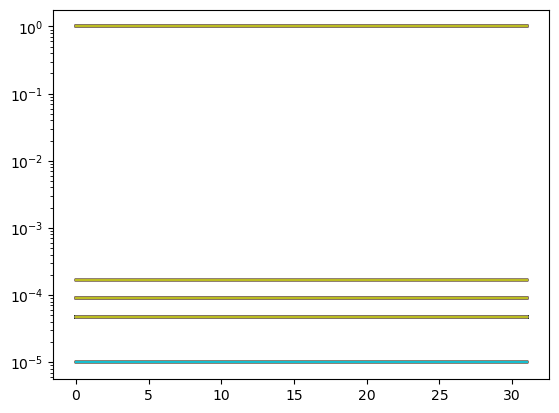

In [95]:
print("\n" + "="*60)
print("MASS MATRICES (INVERSE)")
print("="*60)

mass_matrices = []
for i in range(num_trajectories):
    mass_matrix = jax.tree_map(lambda x: x[i], adaptation_states.inverse_mass_matrix)
    plt.plot(mass_matrix)
    # mass_matrices.append(mass_matrix)
    # print(f"\nTrajectory {i}:")
    # # Print structure
    # if isinstance(mass_matrix, dict):
    #     for key, val in list(mass_matrix.items())[:3]:  # First 3 params
    #         print(f"  {key}: {val}")
    # else:
    #     print(f"  {mass_matrix}")

plt.yscale('log')

In [96]:
# =============================================================================
# 6. EXTRACT LOG PROBABILITIES
# =============================================================================

print("\n" + "="*60)
print("LOG PROBABILITIES")
print("="*60)

log_probs = [float(hmc_states.logdensity[i]) for i in range(num_trajectories)]
print(f"Log probabilities: {[f'{x:.4f}' for x in log_probs]}")

# # =============================================================================
# # 7. EXTRACT ACCEPTANCE INFORMATION
# # =============================================================================

# print("\n" + "="*60)
# print("ACCEPTANCE INFORMATION")
# print("="*60)

# is_accepted = [bool(nuts_infos.is_accepted[i]) for i in range(num_trajectories)]
# print(f"Accepted: {is_accepted}")
# print(f"Acceptance rate: {sum(is_accepted)/len(is_accepted):.2%}")

# Energy information
energy = [float(nuts_infos.energy[i]) for i in range(num_trajectories)]
print(f"Energy: {[f'{x:.4f}' for x in energy]}")



LOG PROBABILITIES
Log probabilities: ['-26113817.5625', '-26113817.5625', '-26113817.5625', '-26113817.5625', '-26113817.5625', '-26113817.5625', '-10824691.9341', '-1458564.1529', '-1458564.1529', '-1401481.3911', '-1325956.6343', '-1325956.6343', '-1303465.3491', '-1266602.3238', '-1266602.3238', '-1184817.8741', '-1135342.4892', '-713870.3229', '-713870.3229', '-274570.9099', '-268217.4516', '-268217.4516', '-266619.3927', '-266619.3927', '-135690.5051', '-111494.4692', '-111494.4692', '-108312.0399', '-108043.9949', '-90750.3882', '-89148.3290', '-86640.2600', '-86640.2600', '-86562.2450', '-86562.2450', '-86181.1945', '-86164.3694', '-86031.2424', '-85861.9413', '-85656.1686', '-85357.3540', '-83421.1228', '-83310.7713', '-83159.1456', '-82977.5997', '-82908.2461', '-82908.8509', '-82908.9028', '-82905.0925', '-82908.5999', '-82906.0218', '-82907.7221', '-82906.6754', '-82907.4237', '-82906.8125', '-82907.4736', '-82905.9511', '-82904.5734', '-82904.9048', '-82906.1916', '-82905.

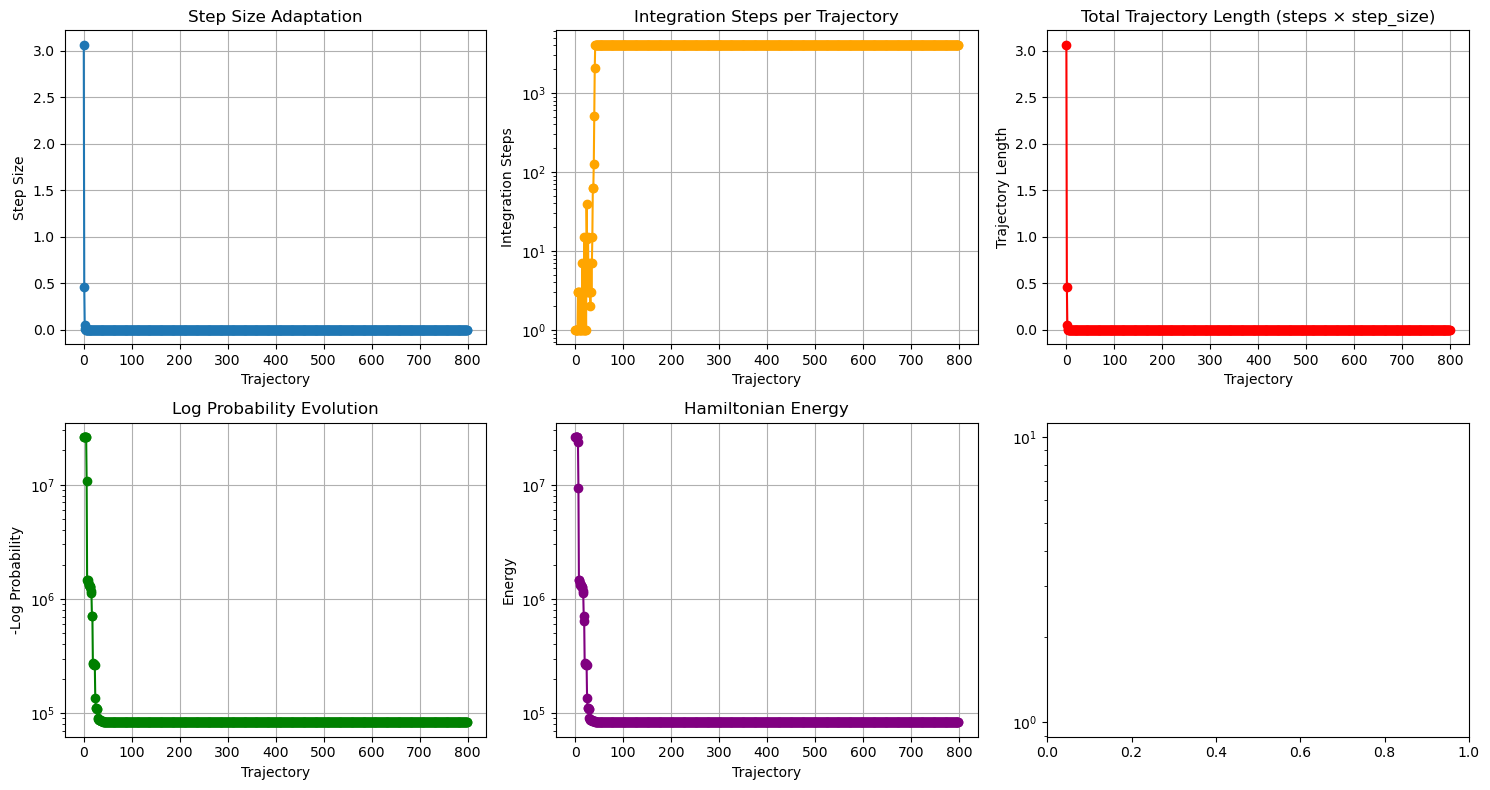

In [103]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Step size evolution
axes[0, 0].plot(range(num_trajectories), step_sizes, 'o-')
axes[0, 0].set_xlabel('Trajectory')
axes[0, 0].set_ylabel('Step Size')
axes[0, 0].set_title('Step Size Adaptation')
axes[0, 0].grid(True)
plt.yscale('log')

# Number of integration steps
axes[0, 1].plot(range(num_trajectories), num_integration_steps, 'o-', color='orange')
axes[0, 1].set_xlabel('Trajectory')
axes[0, 1].set_ylabel('Integration Steps')
axes[0, 1].set_title('Integration Steps per Trajectory')
axes[0, 1].grid(True)
axes[0, 1].set_yscale('log')

# Trajectory length
axes[0, 2].plot(range(num_trajectories), trajectory_lengths, 'o-', color='red')
axes[0, 2].set_xlabel('Trajectory')
axes[0, 2].set_ylabel('Trajectory Length')
axes[0, 2].set_title('Total Trajectory Length (steps × step_size)')
axes[0, 2].grid(True)
plt.yscale('log')

# Log probability
axes[1, 0].plot(range(num_trajectories), -1*jnp.array(log_probs), 'o-', color='green')
axes[1, 0].set_xlabel('Trajectory')
axes[1, 0].set_ylabel('-Log Probability')
axes[1, 0].set_title('Log Probability Evolution')
axes[1, 0].grid(True)
axes[1, 0].set_yscale('log')

# Energy
axes[1, 1].plot(range(num_trajectories), energy, 'o-', color='purple')
axes[1, 1].set_xlabel('Trajectory')
axes[1, 1].set_ylabel('Energy')
axes[1, 1].set_title('Hamiltonian Energy')
axes[1, 1].grid(True)
axes[1, 1].set_yscale('log')

# # Acceptance
# axes[1, 2].bar(range(num_trajectories), is_accepted, color=['green' if x else 'red' for x in is_accepted])
# axes[1, 2].set_xlabel('Trajectory')
# axes[1, 2].set_ylabel('Accepted')
# axes[1, 2].set_title('Acceptance per Trajectory')
# axes[1, 2].set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

32


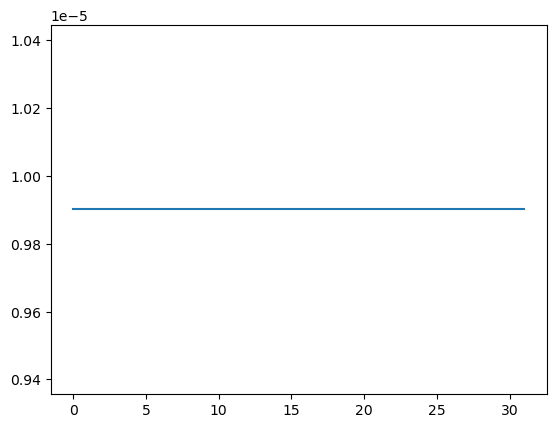

In [104]:
plt.plot(adapted_settings['inverse_mass_matrix'])
print(len(adapted_settings['inverse_mass_matrix']))

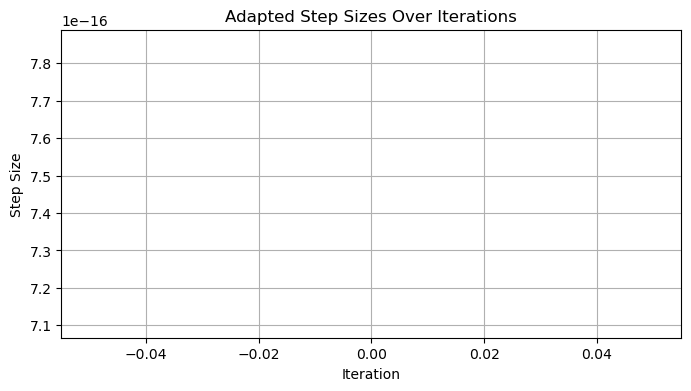

In [105]:
# Plot the step sizes over iterations to see how they adapt
if 'step_size' in adapted_settings:
    step_sizes = adapted_settings['step_size']
    plt.figure(figsize=(8, 4))
    plt.plot(step_sizes)
    plt.xlabel('Iteration')
    plt.ylabel('Step Size')
    plt.title('Adapted Step Sizes Over Iterations')
    plt.grid()
    plt.show()

In [106]:
adapted_settings['step_size']

Array(7.47827597e-16, dtype=float64, weak_type=True)

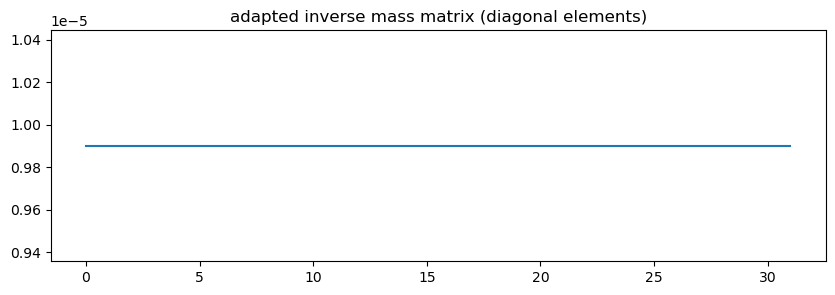

In [107]:
# visualize the inverse mass matrix we will use for HMC

plt.figure(figsize=(10, 3))
plt.title("adapted inverse mass matrix (diagonal elements)")
plt.plot(adapted_settings['inverse_mass_matrix'])
plt.show()

In [ ]:
# setup the NUTS kernel with adapted settings
kernel = blackjax.nuts(logdensity_fn, **adapted_settings).step

# define the inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):

    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

num_steps_nuts = 4000 # number of samples

start = time.time()
states, infos = inference_loop(key_hmc_run, kernel, last_state, num_steps_nuts)
_ = states.position['lens_theta_E'].block_until_ready()
print("Time taken by HMC (blackjax) main phase:", time.time()-start)  

/Users/souvik/miniconda3/envs/herculens-env/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (32), generating only 20 plots
  warnings.warn(


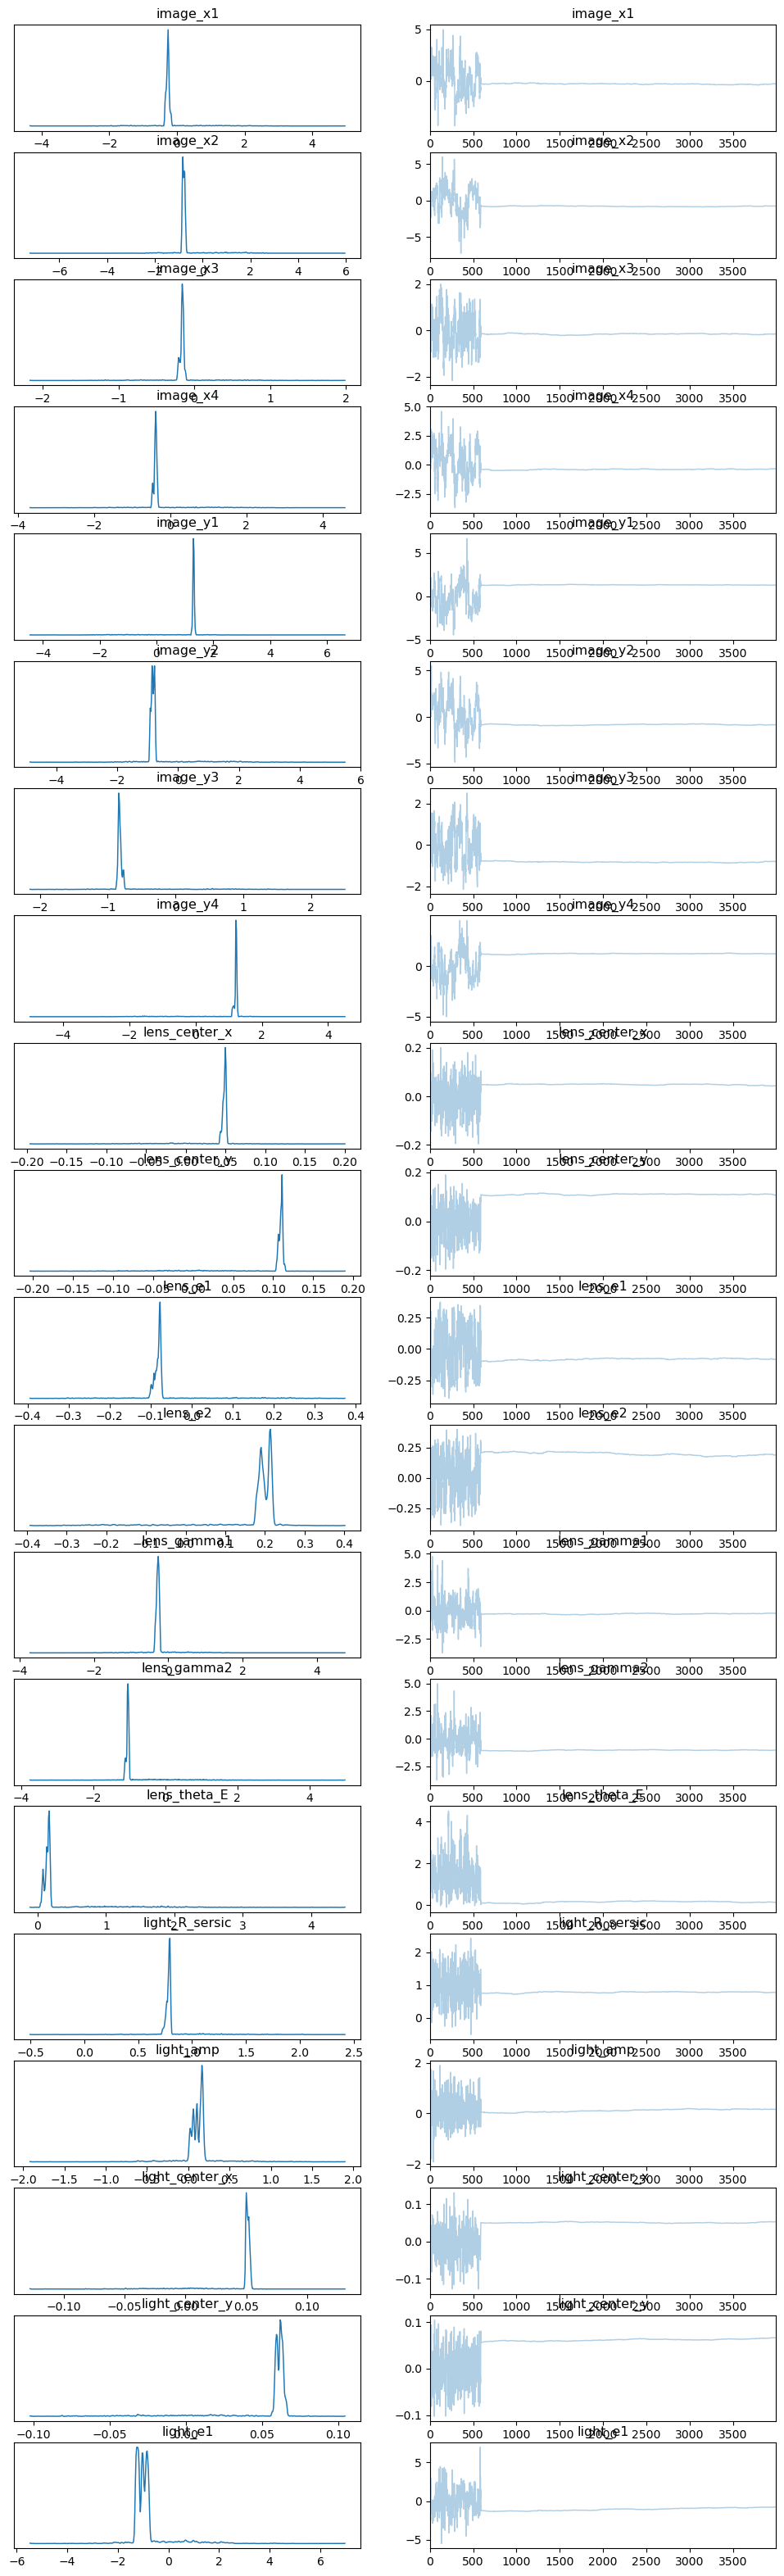

In [65]:
import arviz as az
idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()})
az.plot_trace(idata);

In [66]:
# After running your inference_loop
print("Info fields:", infos._fields)

# Check number of leapfrog steps per iteration
if hasattr(infos, 'num_integration_steps'):
    print("Integration steps per sample:")
    print(infos.num_integration_steps)
    print(f"Mean trajectory length: {infos.num_integration_steps.mean():.1f}")
    print(f"Min: {infos.num_integration_steps.min()}, Max: {infos.num_integration_steps.max()}")

# Check acceptance probability
if hasattr(infos, 'acceptance_rate'):
    print(f"Mean acceptance rate: {infos.acceptance_rate.mean():.3f}")

Info fields: ('momentum', 'is_divergent', 'is_turning', 'energy', 'trajectory_leftmost_state', 'trajectory_rightmost_state', 'num_trajectory_expansions', 'num_integration_steps', 'acceptance_rate')
Integration steps per sample:
[ 652 2047 2047 ...   11    5    7]
Mean trajectory length: 267.1
Min: 3, Max: 4095
Mean acceptance rate: 0.237


In [67]:
print(infos.num_trajectory_expansions)
print(infos.num_integration_steps)

[10 11 11 ...  4  3  3]
[ 652 2047 2047 ...   11    5    7]


In [68]:
print(f"Current step size: {adapted_settings['step_size']}")


Current step size: 0.0019103457557553335


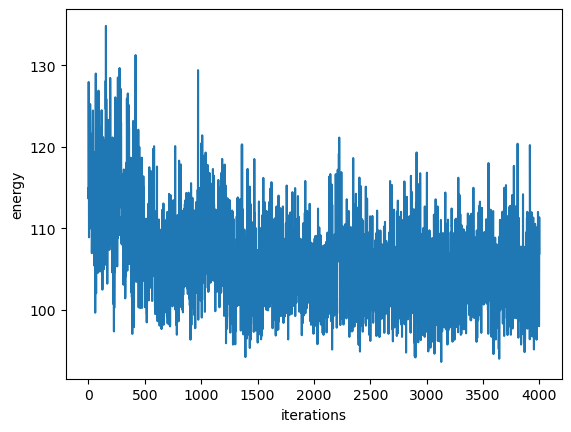

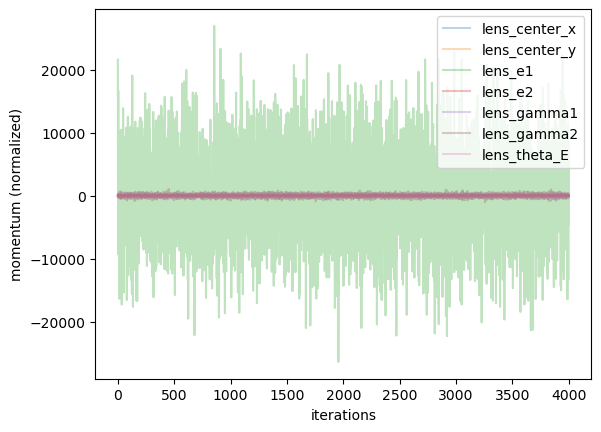

In [69]:
plt.figure()
plt.plot(infos.energy)
plt.xlabel("iterations")
plt.ylabel("energy")
plt.show()

plt.figure()
for k, v in infos.momentum.items():
    if 'lens' in k:
        plt.plot((v - np.median(v)) / np.median(v), label=k, alpha=0.3)
plt.legend()
plt.xlabel("iterations")
plt.ylabel("momentum (normalized)")
plt.show()

In [70]:
infos.energy

Array([114.91351396, 113.62479282, 127.95396447, ..., 100.64978399,
       111.34921474, 106.90459983], dtype=float64)

In [79]:
acceptance_rate = np.mean(infos.acceptance_rate)
num_divergent = np.mean(infos.is_divergent)

print(f"Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

Average acceptance rate: 0.24
There were 78.40% divergent transitions


In [80]:
# retrieve the HMC posterior samples
hmc_samples = jax.vmap(prob_model.constrain)(states.position)
#save the HMC samples to a file hmc_samples_gw.npz
import numpy as np
np.savez('hmc_samples_gw.npz', **hmc_samples)


In [81]:
# Load the samples
data = np.load('hmc_samples_gw.npz',allow_pickle=False)
# hmc_samples = {key: data[key] for key in data.files}
hmc_samples_loaded = {key: data[key] for key in data.files}

In [82]:
# hmc_samples_loaded has shape: {param: (n_samples,)} for each parameter
# We need to constrain each sample individually

# Get number of samples
n_samples = len(list(hmc_samples_loaded.values())[0])

# Constrain each sample one at a time
constrained_samples_list = []

for i in range(n_samples):
    # Extract the i-th sample as a dictionary
    single_sample_unconst = {key: values[i] for key, values in hmc_samples_loaded.items()}
    
    # Constrain this single sample
    single_sample_const = gw_model.constrain(single_sample_unconst)
    
    constrained_samples_list.append(single_sample_const)

# Reorganize back into dictionary format with arrays
hmc_samples_constrain = {}
for key in constrained_samples_list[0].keys():
    hmc_samples_constrain[key] = jnp.array([sample[key] for sample in constrained_samples_list])

print("Constrained samples shape:")
for key, val in hmc_samples_constrain.items():
    print(f"{key}: {val.shape}")

Constrained samples shape:
zs: (4000,)
zl: (4000,)
image_x1: (4000,)
image_y1: (4000,)
image_x2: (4000,)
image_y2: (4000,)
image_x3: (4000,)
image_y3: (4000,)
image_x4: (4000,)
image_y4: (4000,)
source_amp: (4000,)
source_R_sersic: (4000,)
source_n: (4000,)
source_e1: (4000,)
source_e2: (4000,)
source_center_x: (4000,)
source_center_y: (4000,)
light_center_x: (4000,)
light_center_y: (4000,)
light_e1: (4000,)
light_e2: (4000,)
light_amp: (4000,)
light_R_sersic: (4000,)
light_n: (4000,)
lens_theta_E: (4000,)
lens_e1: (4000,)
lens_e2: (4000,)
lens_center_x: (4000,)
lens_center_y: (4000,)
lens_gamma1: (4000,)
lens_gamma2: (4000,)
noise_sigma_bkg: (4000,)


In [83]:
hmc_samples_constrain['lens_theta_E']

Array([9.99683141, 9.99651401, 9.99917225, ..., 9.95011393, 9.95011393,
       9.94991567], dtype=float64)

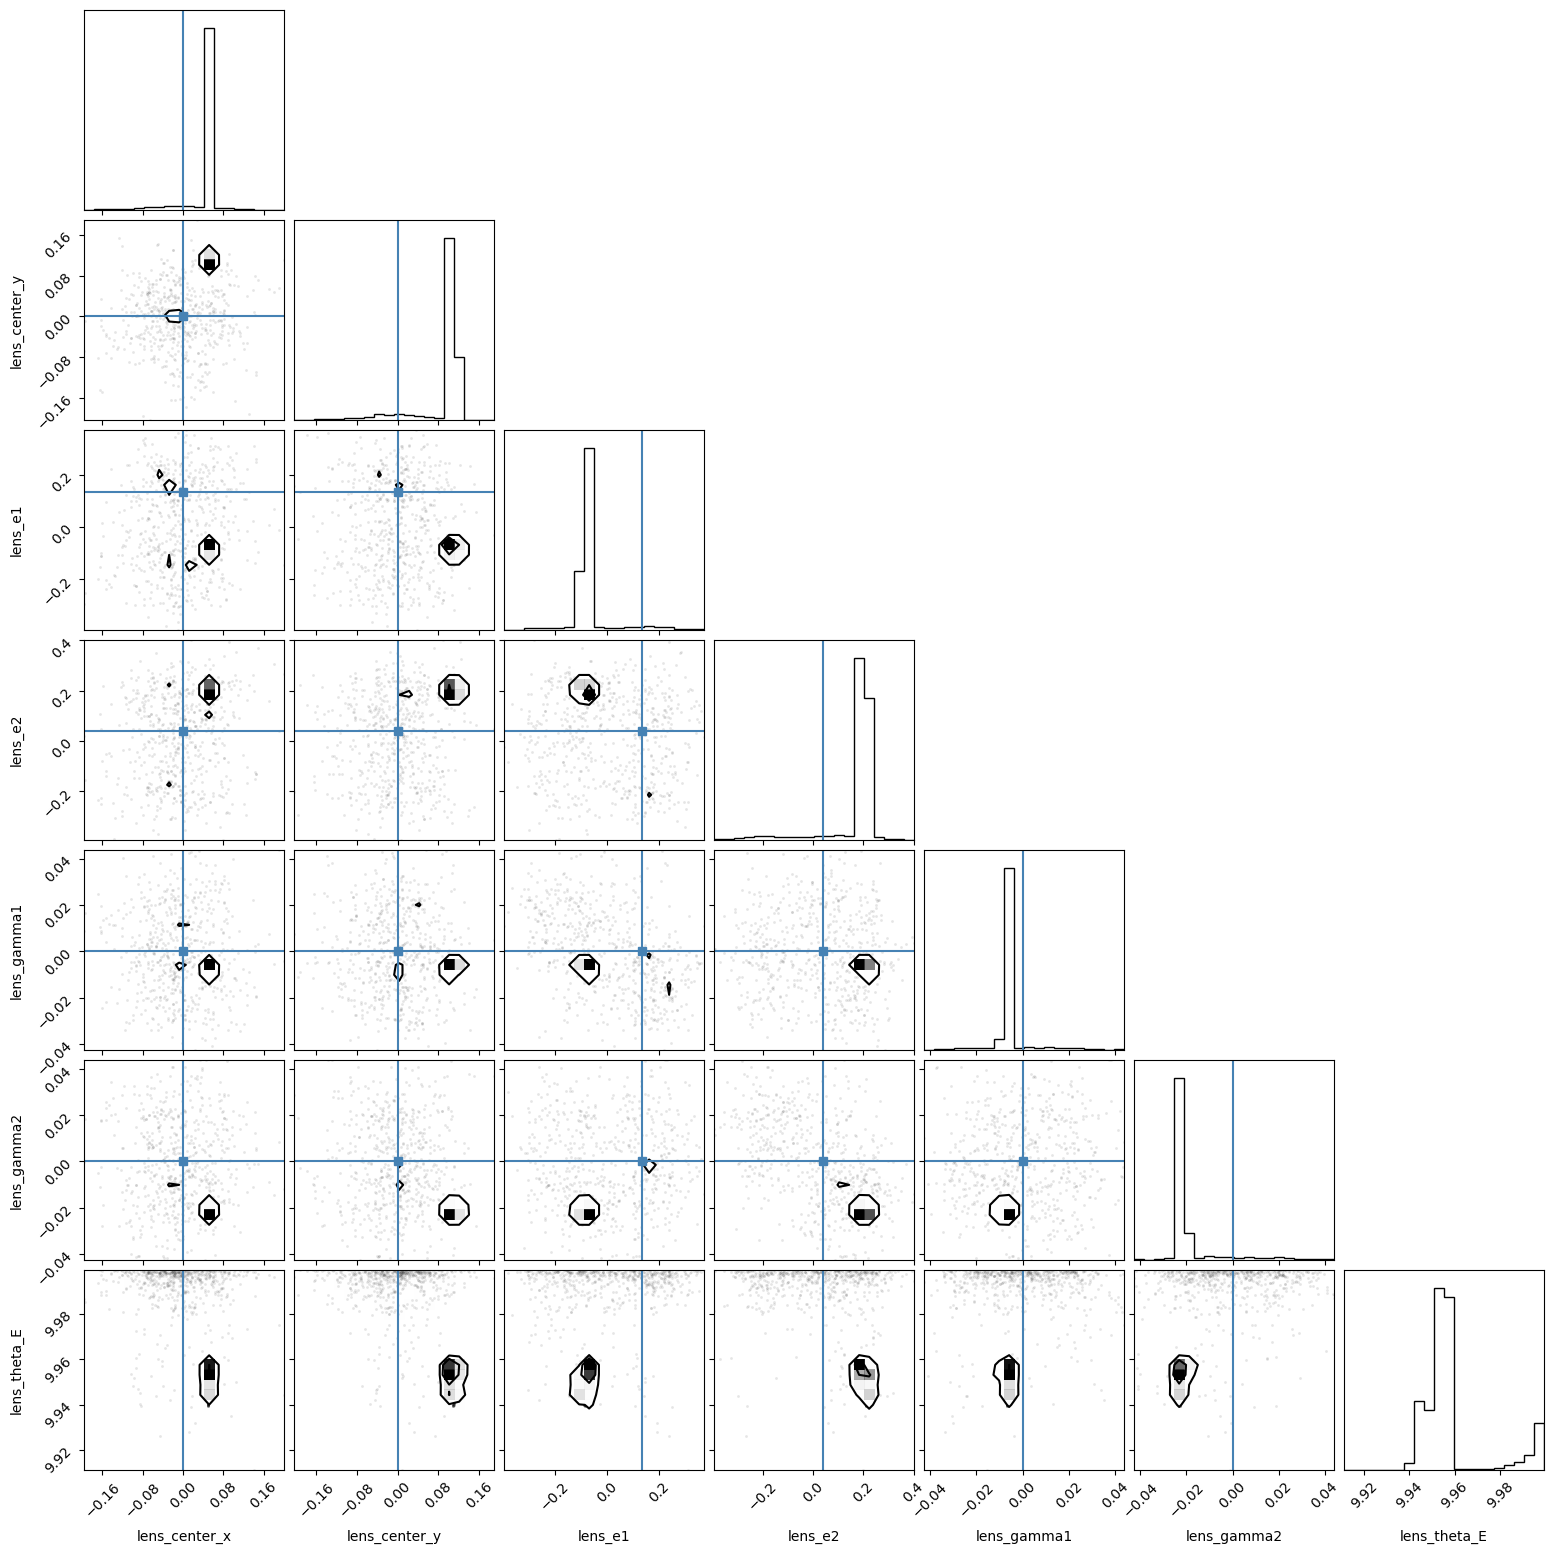

In [85]:
# Corner plot of the posterior distribution
import corner
labels = list(hmc_samples_loaded.keys())
# Select a subset of parameters for the corner plot
# all params with 'lens' in their name
params_to_plot = [label for label in labels if 'lens' in label]
samples_to_plot = np.vstack([hmc_samples_constrain[param] for param in params_to_plot]).T  
figure = corner.corner(samples_to_plot, labels=params_to_plot, truths=[input_params[param] for param in params_to_plot])
plt.show()

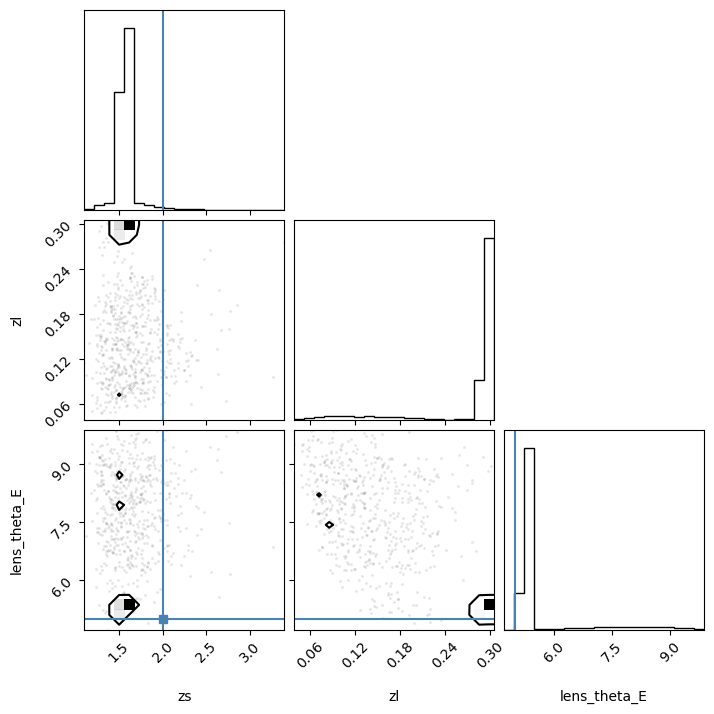

In [78]:
labels = list(hmc_samples_loaded.keys())
# Select a subset of parameters for the corner plot
# all params with 'lens' in their name
# params_to_plot = [label for label in labels if 'lens' in label]
params_to_plot = ['zs','zl','lens_theta_E']
samples_to_plot = np.vstack([hmc_samples_loaded[param] for param in params_to_plot]).T  
figure = corner.corner(samples_to_plot, labels=params_to_plot, truths=[input_params[param] for param in params_to_plot])
plt.show()